# Imports

In [28]:
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Iterable
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.axes
import itertools
import numpy as np
from pprint import pprint
from typing import List

# Original code


--- Run 1 ---
[Item(sku='S1_1', slot='A10_06'), Item(sku='S1_2', slot='A1_02'), Item(sku='S1_3', slot='A4_01'), Item(sku='S2_1', slot='A8_02'), Item(sku='S3_1', slot='A7_04'), Item(sku='S3_2', slot='A1_09'), Item(sku='S3_3', slot='A6_07'), Item(sku='S4_1', slot='A7_12'), Item(sku='S4_2', slot='A6_05'), Item(sku='S5_1', slot='A1_06'), Item(sku='S5_2', slot='A10_05'), Item(sku='S5_3', slot='A9_02'), Item(sku='S5_4', slot='A8_04'), Item(sku='S6_1', slot='A4_14'), Item(sku='S7_1', slot='A2_11'), Item(sku='S7_2', slot='A7_14'), Item(sku='S8_1', slot='A4_09'), Item(sku='S8_2', slot='A3_07'), Item(sku='S8_3', slot='A7_10'), Item(sku='S9_1', slot='A7_02'), Item(sku='S9_2', slot='A10_03'), Item(sku='S10_1', slot='A7_13'), Item(sku='S10_2', slot='A3_14'), Item(sku='S10_3', slot='A2_13'), Item(sku='S11_1', slot='A9_12'), Item(sku='S11_2', slot='A2_14'), Item(sku='S11_3', slot='A7_09'), Item(sku='S11_4', slot='A10_11'), Item(sku='S12_1', slot='A9_03'), Item(sku='S12_2', slot='A2_14'), Item(sku='S

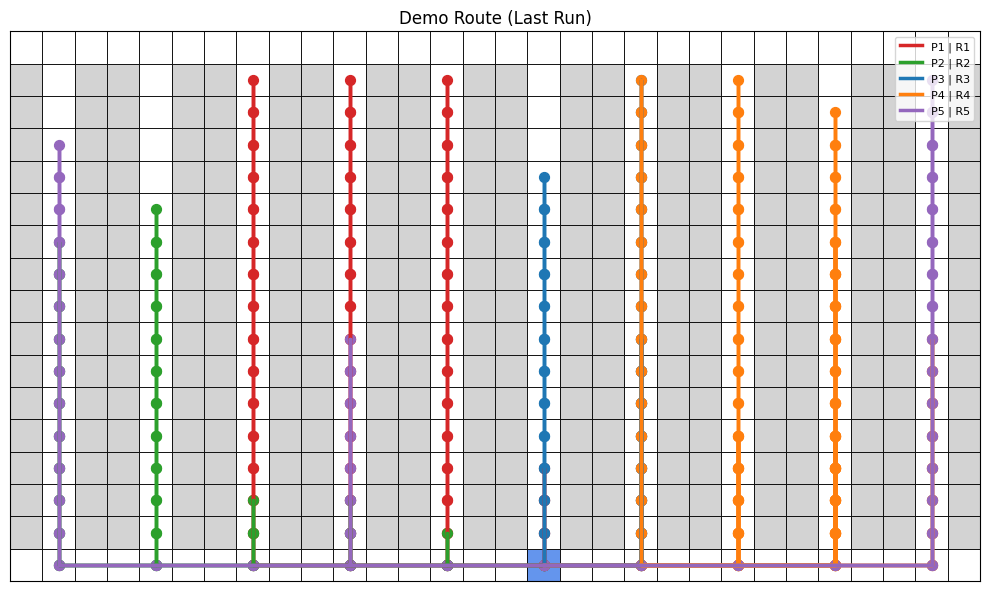

In [ ]:
COLORS = {
    "back": "white",
    "front": "white",
    "aisle": "white",
    "io": "cornflowerblue",
    "slot": "lightgray",
}


@dataclass
class NodeGrid:
    """Grid representation of a node in the warehouse."""

    row: int
    col: int
    node_type: str  # 'front', 'back', 'aisle', 'slot', 'io'
    is_io: bool = False

    def __post_init__(self) -> None:
        """Initialize the color based on the node type."""
        if self.node_type in COLORS:
            self.color = COLORS["io"] if self.is_io else COLORS[self.node_type]
        else:
            self.color = "white"

        self.id = f"{self.node_type[0].upper()}{self.row}_{self.col}"

    def __str__(self) -> str:
        """String representation of the node."""
        return self.id


@dataclass
class Node:
    """Represents a location node in the warehouse."""

    aisle: int
    slot: int
    node_type: str  # 'front', 'back', or 'slot'
    x_coord: float
    y_coord: float
    grid_coord: Tuple[int, int] = field(default_factory=tuple)
    is_io: bool = False

    @property
    def id(self) -> str:
        """Generate a unique identifier for the node."""
        if self.node_type == "front":
            return f"F{self.aisle}"
        elif self.node_type == "back":
            return f"B{self.aisle}"
        elif self.node_type == "slot":
            return f"A{self.aisle}_{self.slot:02d}"
        raise ValueError(f"Unknown node type: {self.node_type}")


@dataclass
class Item:
    """Represents an item in an order."""

    sku: str
    slot: str


@dataclass
class Order:
    """Represents a customer order."""

    order_id: str
    items: List[Item]
    size: int  # number of items


@dataclass
class Route:
    """Represents a picking route for a single picker."""

    route_id: str
    picker_id: str
    orders: List[str]
    path: List[str]


@dataclass
class Solution:
    """Container for a complete routing solution."""

    routes: List[Route]


@dataclass
class Warehouse:
    """
    Warehouse configuration and operations.

    Parameters
    ----------
    num_aisles : int
        Number of parallel aisles in the warehouse.
    slots_per_side : int
        Number of storage locations per side of each aisle.
    aisle_length_m : float
        Length of each aisle in meters.
    aisle_spacing_m : float
        Spacing between aisles in meters.
    slot_pitch_m : float
        Pitch between slots in meters.
    io_node : str
        Identifier of the input/output node.

    Attributes
    ----------
    nodes : List[Node]
        All nodes in the warehouse.
    slot_nodes : List[Node]
        Slot nodes.
    front_nodes : List[Node]
        Front cross-aisle nodes.
    back_nodes : List[Node]
        Back cross-aisle nodes.
    adjacency_dict : Dict[str, List[str]]
        Adjacency dictionary for the graph.
    adjacency_matrix : pd.DataFrame
        Adjacency matrix for the graph.
    slot_dict : Dict[str, Node]
        Dictionary of slot nodes by ID.
    node_df : pd.DataFrame
        DataFrame of all nodes.
    grid : List[List[NodeGrid]]
        Grid representation of the warehouse.
    """

    num_aisles: int
    slots_per_side: int
    aisle_length_m: float
    aisle_spacing_m: float
    slot_pitch_m: float
    io_node: str

    nodes: List[Node] = field(default_factory=list, init=False, repr=False)
    slot_nodes: List[Node] = field(default_factory=list, init=False, repr=False)
    front_nodes: List[Node] = field(default_factory=list, init=False, repr=False)
    back_nodes: List[Node] = field(default_factory=list, init=False, repr=False)

    def __post_init__(self) -> None:
        """Initialize the warehouse nodes and related structures."""
        self.generate_nodes()
        self.adjacency_dict = self._create_adjacency_dict()
        self.adjacency_matrix = self._create_adjacency_matrix()
        self.slot_dict = {node.id: node for node in self.slot_nodes}
        self.node_df = self._create_node_dataframe()
        self.grid = self._create_node_grid()
        self.grid_repr = self._create_grid_repr()

    def generate_nodes(self) -> None:
        """Generate all warehouse nodes (slots, front, and back cross-aisles)."""
        # Create slot nodes
        self.slot_nodes = [
            Node(
                aisle=aisle,
                slot=slot_num,
                node_type="slot",
                x_coord=(aisle - 1) * self.aisle_spacing_m,
                y_coord=slot_num * self.slot_pitch_m,
                grid_coord=(aisle * 3 - 2, slot_num),
            )
            for aisle in range(1, self.num_aisles + 1)
            for slot_num in range(1, self.slots_per_side + 1)
        ]

        # Create front cross-aisle nodes
        self.front_nodes = [
            Node(
                aisle=aisle,
                slot=0,
                node_type="front",
                y_coord=0.0,
                x_coord=(aisle - 1) * self.aisle_spacing_m,
                is_io=(f"F{aisle}" == self.io_node),
                grid_coord=(aisle * 3 - 2, 0),
            )
            for aisle in range(1, self.num_aisles + 1)
        ]

        # Create back cross-aisle nodes
        self.back_nodes = [
            Node(
                aisle=aisle,
                slot=self.slots_per_side + 1,
                node_type="back",
                x_coord=(aisle - 1) * self.aisle_spacing_m,
                y_coord=self.aisle_length_m,
                is_io=(f"B{aisle}" == self.io_node),
                grid_coord=(aisle * 3 - 2, self.slots_per_side + 1),
            )
            for aisle in range(1, self.num_aisles + 1)
        ]

        # Combine all nodes
        self.nodes = self.front_nodes + self.slot_nodes + self.back_nodes

        # Node dict for quick lookup
        self.node_dict: Dict[str, Node] = {node.id: node for node in self.nodes}

    @property
    def grid_height(self) -> int:
        """Calculate the height of the warehouse grid."""
        return self.slots_per_side + 2

    @property
    def grid_width(self) -> int:
        """Calculate the total width of the warehouse in grid units."""
        return self.num_aisles * 3

    @property
    def grid_dimensions(self) -> Tuple[int, int]:
        """Return the dimensions of the warehouse grid (rows, columns)."""
        return self.grid_height, self.grid_width

    @property
    def grid_coord_io(self) -> Tuple[int, int]:
        """Get the grid coordinates of the I/O node."""
        depot_col = int(self.io_node[1:]) * 3 - 2
        depot_row = 0 if self.io_node.startswith("F") else self.grid_height - 1
        return depot_row, depot_col

    def generate_layout_text(self, spacing: int = 5) -> str:
        """
        Generate a textual representation of the warehouse layout with node IDs.

        Parameters
        ----------
        spacing : int, optional
            Spacing for centering node IDs (default is 5).

        Returns
        -------
        str
            Textual representation of the warehouse layout.
        """
        grid = [[" " for _ in range(self.grid_width)] for _ in range(self.grid_height)]

        # Populate front cross aisle
        for front_node in self.front_nodes:
            col = (front_node.aisle - 1) * 3 + 1  # Middle column
            grid[0][col] = f"{front_node.id}{'*' if front_node.is_io else ''}"

        # Populate back cross aisle
        for back_node in self.back_nodes:
            col = (back_node.aisle - 1) * 3 + 1  # Middle column
            grid[-1][col] = f"{back_node.id}{'*' if back_node.is_io else ''}"

        # Populate aisle slots
        for slot_node in self.slot_nodes:
            col = (slot_node.aisle - 1) * 3 + 1  # Middle column
            row = slot_node.slot
            grid[row][col] = slot_node.id

        return "\n".join("".join(f"{cell}".center(spacing) for cell in row) for row in grid)

    def _create_node_grid(self) -> List[List[NodeGrid]]:
        """
        Generate a grid of NodeGrid objects representing the warehouse layout.

        Returns
        -------
        List[List[NodeGrid]]
            Grid of warehouse nodes.
        """
        num_rows = self.grid_height
        num_cols = self.grid_width

        # Initialize grid
        grid = [[" " for _ in range(num_cols)] for _ in range(num_rows)]

        for row_idx in range(num_rows):
            for col_idx in range(num_cols):
                is_cross_aisle = row_idx == 0 or row_idx == num_rows - 1
                is_shelf_column = col_idx % 3 != 1

                if not is_cross_aisle and is_shelf_column:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "slot")
                elif is_cross_aisle and row_idx == num_rows - 1:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "back")
                elif is_cross_aisle and row_idx == 0:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "front")
                else:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "aisle")

        depot_row, depot_col = self.grid_coord_io
        grid[depot_row][depot_col] = NodeGrid(depot_row, depot_col, "front", is_io=True)

        return grid

    def _create_grid_repr(self, show_coords: bool = False, spacing: int = 6) -> str:
        """
        Generate a character-based grid representation of the warehouse layout.

        Parameters
        ----------
        show_coords : bool, optional
            Whether to show coordinates (default is False).
        spacing : int, optional
            Spacing for centering cells (default is 3).

        Returns
        -------
        str
            Textual grid representation.
        """
        num_rows, num_cols = self.grid_dimensions
        grid = [[" " for _ in range(num_cols)] for _ in range(num_rows)]
        
        for row_idx in range(num_rows):
            for col_idx in range(num_cols):
                grid[row_idx][col_idx] = str(self.grid[row_idx][col_idx])

        if show_coords:
            # Add row labels
            for row_idx in range(num_rows):
                grid[row_idx].insert(0, f"{row_idx}".center(spacing))

            # Add column header row
            col_header = [f"{col_idx}".center(spacing) for col_idx in range(num_cols)]
            col_header.insert(0, "".center(spacing))
            grid.insert(0, col_header)

        return "\n".join("".join(f"{cell}".center(spacing) for cell in row) for row in grid)

    def _create_node_dataframe(self) -> pd.DataFrame:
        """
        Generate a DataFrame representation of the warehouse nodes.

        Returns
        -------
        pd.DataFrame
            DataFrame containing node information.
        """
        return pd.DataFrame(
            [
                {
                    "id": node.id,
                    "aisle": node.aisle,
                    "slot": node.slot,
                    "type": node.node_type,
                    "x": node.x_coord,
                    "y": node.y_coord,
                    "is_io": node.is_io,
                }
                for node in self.nodes
            ]
        )

    def is_front_node(self, node_id: str) -> bool:
        """Check if a node is a front cross-aisle node."""
        return node_id.startswith("F")

    def is_back_node(self, node_id: str) -> bool:
        """Check if a node is a back cross-aisle node."""
        return node_id.startswith("B")

    def is_slot_node(self, node_id: str) -> bool:
        """Check if a node is a slot node."""
        return node_id.startswith("A")

    def parse_cross_node(self, node_id: str) -> Tuple[str, int]:
        """
        Parse a cross-aisle node identifier (e.g., 'F1' -> ('F', 1)).

        Parameters
        ----------
        node_id : str
            Node identifier.

        Returns
        -------
        Tuple[str, int]
            Type and aisle number.
        """
        return node_id[0], int(node_id[1:])

    def parse_slot_node(self, node_id: str) -> Tuple[str, int, int]:
        """
        Parse a slot node identifier (e.g., 'A12_34' -> ('A', 12, 34)).

        Parameters
        ----------
        node_id : str
            Node identifier.

        Returns
        -------
        Tuple[str, int, int]
            Type, aisle, slot.
        """
        side = node_id[0]
        aisle_str, slot_str = node_id[1:].split("_")
        return side, int(aisle_str), int(slot_str)

    def are_adjacent(self, node_u: str, node_v: str) -> bool:
        """
        Determine if two nodes are adjacent in the warehouse graph.

        Parameters
        ----------
        node_u : str
            First node ID.
        node_v : str
            Second node ID.

        Returns
        -------
        bool
            True if adjacent, False otherwise.
        """
        # Cross-aisle to cross-aisle (same type)
        if (self.is_front_node(node_u) and self.is_front_node(node_v)) or (
            self.is_back_node(node_u) and self.is_back_node(node_v)
        ):
            _, aisle_i = self.parse_cross_node(node_u)
            _, aisle_j = self.parse_cross_node(node_v)
            return abs(aisle_i - aisle_j) == 1

        # Front to slot
        if self.is_front_node(node_u) and self.is_slot_node(node_v):
            _, aisle, slot_num = self.parse_slot_node(node_v)
            return self.parse_cross_node(node_u)[1] == aisle and slot_num == 1

        # Back to slot
        if self.is_back_node(node_u) and self.is_slot_node(node_v):
            _, aisle, slot_num = self.parse_slot_node(node_v)
            return self.parse_cross_node(node_u)[1] == aisle and slot_num == self.slots_per_side

        # Slot to cross-aisle (symmetric check)
        if self.is_slot_node(node_u) and (self.is_front_node(node_v) or self.is_back_node(node_v)):
            return self.are_adjacent(node_v, node_u)

        # Slot to slot (same aisle, consecutive slots)
        if self.is_slot_node(node_u) and self.is_slot_node(node_v):
            _, aisle_u, slot_u = self.parse_slot_node(node_u)
            _, aisle_v, slot_v = self.parse_slot_node(node_v)
            return aisle_u == aisle_v and abs(slot_u - slot_v) == 1

        return False

    def _create_adjacency_dict(self) -> Dict[str, List[str]]:
        """
        Create an adjacency dictionary for the warehouse graph.

        Returns
        -------
        Dict[str, List[str]]
            Adjacency dictionary.
        """
        adj_dict = {}
        node_ids = [node.id for node in self.nodes]

        for node_u in node_ids:
            adj_dict[node_u] = [
                node_v for node_v in node_ids if node_u != node_v and self.are_adjacent(node_u, node_v)
            ]

        return adj_dict

    def _create_adjacency_matrix(self) -> pd.DataFrame:
        """
        Create an adjacency matrix for the warehouse graph.

        Returns
        -------
        pd.DataFrame
            Adjacency matrix.
        """
        node_ids = [node.id for node in self.nodes]
        adj_matrix = pd.DataFrame(0, index=node_ids, columns=node_ids)

        for i, node_u in enumerate(node_ids):
            for j, node_v in enumerate(node_ids):
                if i != j and self.are_adjacent(node_u, node_v):
                    adj_matrix.at[node_u, node_v] = 1

        return adj_matrix

    def calculate_step_cost(self, node_u: str, node_v: str) -> float:
        """
        Calculate the cost of moving between two adjacent nodes.

        Parameters
        ----------
        node_u : str
            Starting node ID.
        node_v : str
            Ending node ID.

        Returns
        -------
        float
            Step cost in meters.

        Raises
        ------
        ValueError
            If nodes are not adjacent.
        """
        if not self.are_adjacent(node_u, node_v):
            raise ValueError(f"Nodes are not adjacent: {node_u} -> {node_v}")

        # Cross-aisle to cross-aisle
        if (self.is_front_node(node_u) and self.is_front_node(node_v)) or (
            self.is_back_node(node_u) and self.is_back_node(node_v)
        ):
            return self.aisle_spacing_m

        # Front to slot or slot to front
        if (self.is_front_node(node_u) and self.is_slot_node(node_v)) or (
            self.is_slot_node(node_u) and self.is_front_node(node_v)
        ):
            slot_num = (
                self.parse_slot_node(node_v)[2]
                if self.is_slot_node(node_v)
                else self.parse_slot_node(node_u)[2]
            )
            return slot_num * self.slot_pitch_m

        # Back to slot or slot to back
        if (self.is_back_node(node_u) and self.is_slot_node(node_v)) or (
            self.is_slot_node(node_u) and self.is_back_node(node_v)
        ):
            slot_num = (
                self.parse_slot_node(node_v)[2]
                if self.is_slot_node(node_v)
                else self.parse_slot_node(node_u)[2]
            )
            return abs(self.aisle_length_m - slot_num * self.slot_pitch_m)

        # Slot to slot (same aisle)
        return self.slot_pitch_m

    def get_node_coordinates(self, node_id: str) -> Tuple[float, float]:
        """
        Calculate the coordinates of a node in the warehouse.

        Parameters
        ----------
        node_id : str
            Node identifier.

        Returns
        -------
        Tuple[float, float]
            (x, y) coordinates.
        """
        if self.is_front_node(node_id) or self.is_back_node(node_id):
            front_back, aisle = self.parse_cross_node(node_id)
            y_coord = 0.0 if front_back == "F" else self.aisle_length_m
            return (aisle - 1) * self.aisle_spacing_m, y_coord

        _, aisle, slot_num = self.parse_slot_node(node_id)
        return (aisle - 1) * self.aisle_spacing_m, slot_num * self.slot_pitch_m

    def calculate_path_distance(self, path: List[str]) -> float:
        """
        Calculate the total distance of a given path.

        Parameters
        ----------
        path : List[str]
            List of node IDs in the path.

        Returns
        -------
        float
            Total distance in meters.
        """
        return sum(self.calculate_step_cost(u, v) for u, v in zip(path, path[1:]))

    def validate_path(self, path: List[str], required_slots: Iterable[str]) -> Tuple[bool, str]:
        """
        Validate a picking path.

        Parameters
        ----------
        path : List[str]
            List of node IDs in the path.
        required_slots : Iterable[str]
            Required slot nodes to visit.

        Returns
        -------
        Tuple[bool, str]
            (Valid, Message).
        """
        if not path:
            return False, "Empty path"

        # Check start and end at I/O
        if path[0] != self.io_node or path[-1] != self.io_node:
            return False, "Path must start and end at I/O"

        # Check adjacency
        for u, v in zip(path, path[1:]):
            if not self.are_adjacent(u, v):
                return False, f"Non-adjacent step {u} -> {v}"

        # Check required slots visited
        needed_slots = set(required_slots)
        visited_slots = set(node_id for node_id in path if self.is_slot_node(node_id))

        if not needed_slots.issubset(visited_slots):
            return False, f"Missing slots: {sorted(needed_slots - visited_slots)}"

        return True, "OK"

    def validate_solution(self, solution: Solution, orders: List[Order]) -> Tuple[bool, str]:
        """
        Validate a complete solution.

        Parameters
        ----------
        solution : Solution
            The solution to validate.
        orders : List[Order]
            List of orders.

        Returns
        -------
        Tuple[bool, str]
            (Valid, Message).
        """
        orders_by_id = {order.order_id: order for order in orders}
        assigned_orders = {order_id: False for order_id in orders_by_id}

        for route in solution.routes:
            required_slots = get_required_slots_for_orders(route.orders, orders)
            is_valid, message = self.validate_path(route.path, required_slots)
            if not is_valid:
                return False, f"Route {route.route_id}: {message}"

            for order_id in route.orders:
                if assigned_orders[order_id]:
                    return False, f"Order {order_id} appears in multiple routes"
                assigned_orders[order_id] = True

        unassigned_orders = [order_id for order_id, assigned in assigned_orders.items() if not assigned]
        if unassigned_orders:
            return False, f"Unassigned orders: {unassigned_orders}"

        return True, "OK"

    def calculate_solution_distance(self, solution: Solution) -> float:
        """
        Calculate total distance for all routes in solution.

        Parameters
        ----------
        solution : Solution
            The solution.

        Returns
        -------
        float
            Total distance in meters.
        """
        return sum(self.calculate_path_distance(route.path) for route in solution.routes)

    def calculate_solution_travel_time(self, solution: Solution, speed_mps: float = 1.2) -> float:
        """
        Calculate total travel time for all routes in solution.

        Parameters
        ----------
        solution : Solution
            The solution.
        speed_mps : float, optional
            Walking speed in meters per second (default is 1.2).

        Returns
        -------
        float
            Total travel time in seconds.
        """
        total_distance = self.calculate_solution_distance(solution)
        return total_distance / speed_mps if speed_mps > 0 else 0.0

    def calculate_route_time_seconds(
        self,
        route: Route,
        orders: List[Order],
        speed_mps: float = 1.2,
        pick_time_sec: float = 3.0,
    ) -> float:
        """
        Calculate travel time + pick handling time for a route.

        Parameters
        ----------
        route : Route
            The route.
        orders : List[Order]
            List of all orders.
        speed_mps : float, optional
            Walking speed in m/s (default is 1.2).
        pick_time_sec : float, optional
            Time to pick one item in seconds (default is 3.0).

        Returns
        -------
        float
            Total time in seconds.
        """
        distance = self.calculate_path_distance(route.path)
        item_count = get_item_count_for_orders(route.orders, orders)
        travel_time = distance / max(speed_mps, 1e-6)
        handling_time = item_count * pick_time_sec
        return travel_time + handling_time

    def calculate_picker_finish_times(
        self,
        solution: Solution,
        orders: List[Order],
        speed_mps: float = 1.2,
        pick_time_sec: float = 3.0,
    ) -> Dict[str, float]:
        """
        Calculate finish time (seconds) per picker.

        Parameters
        ----------
        solution : Solution
            The solution.
        orders : List[Order]
            List of orders.
        speed_mps : float, optional
            Walking speed in m/s (default is 1.2).
        pick_time_sec : float, optional
            Pick time per item in seconds (default is 3.0).

        Returns
        -------
        Dict[str, float]
            Finish times per picker ID.
        """
        routes_per_picker = defaultdict(list)
        for route in solution.routes:
            routes_per_picker[route.picker_id].append(route)

        finish_times = {}
        for picker_id, routes in routes_per_picker.items():
            total_time = sum(
                self.calculate_route_time_seconds(route, orders, speed_mps, pick_time_sec)
                for route in routes
            )
            finish_times[picker_id] = total_time

        return finish_times

    def calculate_solution_makespan(
        self,
        solution: Solution,
        orders: List[Order],
        speed_mps: float = 1.2,
        pick_time_sec: float = 3.0,
    ) -> float:
        """
        Calculate the maximum completion time among all pickers.

        Parameters
        ----------
        solution : Solution
            The solution.
        orders : List[Order]
            List of orders.
        speed_mps : float, optional
            Walking speed in m/s (default is 1.2).
        pick_time_sec : float, optional
            Pick time per item in seconds (default is 3.0).

        Returns
        -------
        float
            Makespan in seconds.
        """
        finish_times = self.calculate_picker_finish_times(solution, orders, speed_mps, pick_time_sec)
        return max(finish_times.values()) if finish_times else 0.0

    def get_all_slots(self) -> List[str]:
        """Get list of all slot node IDs."""
        return [node.id for node in self.slot_nodes]

    def generate_orders(
        self, num_orders: int,  max_items_per_order: int = 6, seed: Optional[int] = 42
    ) -> List[Order]:
        """
        Generate random orders for testing.

        Parameters
        ----------
        num_orders : int
            Number of orders to generate.
        max_items_per_order : int, optional
            Maximum items per order (default is 6).
        seed : int, optional
            Random seed for reproducibility (default is 42).

        Returns
        -------
        List[Order]
            Generated orders.

        Examples
        --------
        >>> wh = Warehouse(...)
        >>> orders = wh.generate_orders(5)
        """

        rnd = random.Random(seed)

        all_slots = self.get_all_slots()
        orders = []

        for order_num in range(1, num_orders + 1):
            item_count = rnd.randint(1, max_items_per_order)

            # Randomly sample unique slots for the order
            chosen_slots = rnd.sample(
                all_slots,
                # Ensure we don't sample more slots than available
                min(item_count, len(all_slots))
            )
            
            items = []
            for item_idx, slot_id in enumerate(chosen_slots):
                sku_id = f"S{order_num}_{item_idx+1}"
                item = Item(sku=sku_id, slot=slot_id)
                items.append(item)

            order = Order(
                order_id=f"O{order_num}",
                items=items,
                size=item_count,
            )

            orders.append(order)

        return orders

    def generate_solution(self, orders: List[Order], policy: callable, bin_size: int) -> Solution:
        """
        Generate a solution using a specified routing policy.

        Parameters
        ----------
        orders : List[Order]
            List of orders.
        policy : callable
            Policy method that takes orders, warehouse, and bin_size.
        bin_size : int
            Maximum number of items.

        Returns
        -------
        Solution
            Generated solution.
        """
        return policy(orders, self, bin_size)


    

    def _node_to_grid_coords(self, node_id: str) -> Tuple[int, int]:
        """
        Convert a node ID to its corresponding grid coordinates in the warehouse.

        Parameters
        ----------
        node_id : str
            The identifier of the node (e.g., 'F1', 'B2', 'A1_03').

        Returns
        -------
        Tuple[int, int]
            The grid coordinates (row, column) of the node.

        Notes
        -----
        - Front nodes are located in the first row (row 0).
        - Back nodes are located in the last row.
        - Slot nodes are located in rows corresponding to their slot number.
        - Columns are determined based on the aisle and node type.
        """

        def _get_aisle_columns(aisle: int) -> Tuple[int, int, int]:
            """
            Calculate the column indices for a given aisle.

            Parameters
            ----------
            aisle : int
                The aisle number.

            Returns
            -------
            Tuple[int, int, int]
                The left, middle, and right column indices for the aisle.
            """
            base_col = (aisle - 1) * 3
            return base_col, base_col + 1, base_col + 2

        # Get the total number of rows in the warehouse grid
        num_rows, _ = self.grid_dimensions

        # Handle front cross-aisle nodes
        if self.is_front_node(node_id):
            aisle = int(node_id[1:])  # Extract aisle number from node ID
            _, mid_col, _ = _get_aisle_columns(aisle)
            return 0, mid_col  # Front nodes are in row 0

        # Handle back cross-aisle nodes
        if self.is_back_node(node_id):
            aisle = int(node_id[1:])  # Extract aisle number from node ID
            _, mid_col, _ = _get_aisle_columns(aisle)
            return num_rows - 1, mid_col  # Back nodes are in the last row

        # Handle slot nodes
        _, aisle, slot_num = self.parse_slot_node(node_id)  # Parse slot node ID
        _, mid_col, _ = _get_aisle_columns(aisle)
        return slot_num, mid_col  # Slot nodes are in rows corresponding to their slot number
    
    
    def _plot_single_route(
        self, ax: matplotlib.axes.Axes, color: str, route: Route
    ) -> None:
        """
        Plots a single route on the warehouse grid.

        Parameters
        ----------
        self : Warehouse
            The warehouse.
        ax : matplotlib.axes.Axes
            The axis.
        color : str
            Color for the route.
        route : Route
            The route.
        """
        # Convert route nodes to grid points
        grid_points = [self._node_to_grid_coords(node_id) for node_id in route.path]

        # Center points
        centered_points = [(col + 0.5, row + 0.5) for row, col in grid_points]
        xs, ys = zip(*centered_points) if centered_points else ([], [])

        # Label the route
        label = f"{route.picker_id} | {route.route_id}"

        # Plot the route as a line
        ax.plot(xs, ys, linewidth=2.5, color=color, label=label)

        ax.scatter(xs, ys, s=50, color=color)

    def _draw_warehouse_grid(self, ax: matplotlib.axes.Axes,) -> None:
        """
        Draws a grid representation of a warehouse layout on the given matplotlib axis.

        Parameters
        ----------
        self : Warehouse
            The warehouse.
        ax : matplotlib.axes.Axes
            The axis to draw on.
        
        """
        grid = self.grid
        num_rows, num_cols = self.grid_dimensions

        for row_idx in range(num_rows):
            for col_idx in range(num_cols):
                color = grid[row_idx][col_idx].color
                rect = plt.Rectangle(
                    (col_idx, row_idx), 1, 1, fc=color, ec="black", lw=0.6
                )
                ax.add_patch(rect)


    def plot_warehouse_routes(
        self, solution: Solution, title: str = "Warehouse routes"
    ) -> None:
        """
        Visualize warehouse routes for order picking.

        Parameters
        ----------
        self : Warehouse
            The warehouse.
        solution : Solution
            The solution object containing the routes.
        title : str, optional
            Plot title (default is "Warehouse routes").
        """
        num_rows, num_cols = self.grid_dimensions

        fig, ax = plt.subplots(figsize=(10, 9))

        self._draw_warehouse_grid(ax)

        color_cycle = itertools.cycle(["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple"])
        for route in solution.routes:
            self._plot_single_route(ax, next(color_cycle), route)

        ax.set_xlim(0, num_cols)
        ax.set_ylim(0, num_rows)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title(title)
        ax.legend(loc="upper right", fontsize=8)
        plt.tight_layout()
        plt.show()



def get_required_slots_for_orders(order_ids: List[str], all_orders: List[Order]) -> List[str]:
    """
    Extract unique slot locations required for given orders.

    Parameters
    ----------
    order_ids : List[str]
        List of order IDs.
    all_orders : List[Order]
        List of all orders.

    Returns
    -------
    List[str]
        Sorted list of required slot IDs.
    """
    return sorted(
        {
            item.slot
            for order in all_orders
            if order.order_id in order_ids
            for item in order.items
        }
    )


def get_item_count_for_orders(order_ids: List[str], all_orders: List[Order]) -> int:
    """
    Count total items across given orders.

    Parameters
    ----------
    order_ids : List[str]
        List of order IDs.
    all_orders : List[Order]
        List of all orders.

    Returns
    -------
    int
        Total item count.
    """
    order_id_set = set(order_ids)
    return sum(order.size for order in all_orders if order.order_id in order_id_set)



def policy_pick_and_return(orders: List[Order], warehouse: Warehouse, bin_size: int) -> Solution:
    """
    Simple policy: pick all items one by one and return to I/O each time.

    Parameters
    ----------
    orders : List[Order]
        List of orders.
    warehouse : Warehouse
        The warehouse.
    bin_size : int
        Maximum number of items (not used in this policy).

    Returns
    -------
    Solution
        Generated solution.
    """
    all_items = [item for order in orders for item in order.items]
    path = []

    io_node = warehouse.node_dict[warehouse.io_node]

    for item in all_items:
        aisle = warehouse.node_dict[item.slot].aisle
        slot_num = warehouse.node_dict[item.slot].slot

        # Path from I/O to front of aisle
        path_from_io_to_front = []
        target_front = warehouse.node_dict[f"F{aisle}"]

        if io_node.aisle > target_front.aisle:
            for k in range(io_node.aisle, target_front.aisle - 1, -1):
                path_from_io_to_front.append(warehouse.node_dict[f"F{k}"])
        elif io_node.aisle < target_front.aisle:
            for k in range(io_node.aisle, target_front.aisle + 1):
                path_from_io_to_front.append(warehouse.node_dict[f"F{k}"])
        else:
            path_from_io_to_front.append(io_node)

        # Path from front to slot
        path_from_front_to_slot = []
        for t in range(1, slot_num + 1):
            path_from_front_to_slot.append(warehouse.node_dict[f"A{aisle}_{t:02d}"])

        # Reverse path to return to front
        path_from_slot_to_front = list(reversed(path_from_front_to_slot[:-1]))  # Exclude slot

        # Reverse path to return to I/O
        path_from_front_to_io = list(reversed(path_from_io_to_front))

        # Combine segments
        path.extend(
            path_from_io_to_front
            + path_from_front_to_slot
            + path_from_slot_to_front
            + path_from_front_to_io[:-1]  # Exclude duplicate I/O
        )

    # Add final I/O
    path.append(io_node)

    # Convert to IDs
    path_ids = [node.id for node in path]

    return Solution(
        routes=[
            Route(
                route_id="R1",
                picker_id="P1",
                orders=[order.order_id for order in orders],
                path=path_ids,
            )
        ]
    )





















# Logic Single order picking

In [ ]:
def policy_single_order_picking(orders: List[Order], warehouse: Warehouse, bin_capacity: int = None) -> Solution:
    """
    Single-order picking policy:
    Each order is picked separately, visiting all required slots via a nearest-neighbor heuristic.
    """
    io_node = warehouse.node_dict[warehouse.io_node]
    routes = []
    for i, order in enumerate(orders, start=1):
        path = [io_node]
        item_in_order = [item for item in order.items]
        counter = 0
        while len(item_in_order) > 0:
            
            last_node = path[-1]
            for item in item_in_order:
                item.aisle = warehouse.node_dict[item.slot].aisle
                item.slot_num = warehouse.node_dict[item.slot].slot
                item.distance = abs(last_node.aisle - item.aisle) * warehouse.aisle_spacing_m + abs(last_node.slot - item.slot_num) * warehouse.slot_pitch_m if last_node.node_type == "slot" else abs(last_node.aisle - item.aisle) * warehouse.aisle_spacing_m + (item.slot_num) * warehouse.slot_pitch_m
            nearest_item = min(
                item_in_order,
                key=lambda item: item.distance
            )
            aisle = warehouse.node_dict[nearest_item.slot].aisle
            print(aisle)
            slot_num = warehouse.node_dict[nearest_item.slot].slot
            # Path from last node to front of aisle
            path_from_last_to_front = []
            if not last_node.aisle == aisle:
                path_from_slot_to_front = []
                # Go to front of current aisle
                for t in range(last_node.slot-1, 0, -1):
                    path_from_slot_to_front.append(warehouse.node_dict[f"A{last_node.aisle}_{t:02d}"])
                # Go to different Isle
                if last_node.aisle > aisle:
                    for k in range(last_node.aisle, aisle - 1, -1):
                        path_from_last_to_front.append(warehouse.node_dict[f"F{k}"])
                elif last_node.aisle < aisle:
                    for k in range(last_node.aisle, aisle + 1):
                        path_from_last_to_front.append(warehouse.node_dict[f"F{k}"])
                # Path from front to slot
                path_from_front_to_slot = []
                for t in range(1, slot_num + 1):
                    path_from_front_to_slot.append(warehouse.node_dict[f"A{aisle}_{t:02d}"])

                # Combine segments 
                # First one does not need to include IO point
                if counter == 0:
                    path.extend(
                        path_from_slot_to_front +
                        path_from_last_to_front[1:]  # skip first since it's the same as last_node
                        + path_from_front_to_slot
                    )
                else:
                    path.extend(
                        path_from_slot_to_front +
                        path_from_last_to_front  # skip first since it's the same as last_node
                        + path_from_front_to_slot
                    )
            else:
                path_from_slot_to_slot = []
                for t in range(last_node.slot+1, slot_num + 1):
                    path_from_slot_to_slot.append(warehouse.node_dict[f"A{aisle}_{t:02d}"])
                path.extend(
                    path_from_slot_to_slot
                )
            counter += 1
            item_in_order.remove(nearest_item)
            print(item_in_order)

        # After each order go back to IO
        if path[-1] != io_node:
            path_from_last_to_io = []
            last_node = path[-1]
            # Go to front of current aisle
            for t in range(last_node.slot-1, 0, -1):
                path_from_last_to_io.append(warehouse.node_dict[f"A{last_node.aisle}_{t:02d}"])
            # Go to IO
            if last_node.aisle > io_node.aisle:
                for k in range(last_node.aisle, io_node.aisle - 1, -1):
                    path_from_last_to_io.append(warehouse.node_dict[f"F{k}"])
            elif last_node.aisle < io_node.aisle:
                for k in range(last_node.aisle, io_node.aisle + 1):
                    path_from_last_to_io.append(warehouse.node_dict[f"F{k}"])
            path.extend(
                path_from_last_to_io
            )

        # Return to I/O only if not already there

        route_ids = [n.id for n in path]
        routes.append(
            Route(
                route_id=f"R{i}",
                picker_id=f"P{i}",
                orders=[order.order_id],
                path=route_ids,
            )
        )
    return Solution(routes=routes)




# Logic Batch order picking

In [ ]:
def policy_batch_order_picking(orders: List[Order], warehouse: Warehouse, bin_capacity: int = None) -> Solution:
    """
    Batch-order picking policy with optional bin capacity:
    Multiple orders are picked in one or more routes. Each route visits all required slots
    via a nearest-neighbor heuristic until the bin is full or all items are picked.
    """

    io_node = warehouse.node_dict[warehouse.io_node]
    all_items = [item for order in orders for item in order.items]
    print(all_items)

    # Collect unique slot IDs (not Item objects)
    unique_slots = set(item.slot for item in all_items)
    print(unique_slots)

    remaining_items = unique_slots.copy()
    item_frequency = {slot_id: 0 for slot_id in unique_slots}

    # Count how many items are in each slot
    for item in all_items:
        item_frequency[item.slot] += 1

    routes = []
    batch_number = 1

    # If no bin capacity is specified, treat as infinite
    if bin_capacity is None or bin_capacity <= 0:
        bin_capacity = len(all_items)

    while len(remaining_items) > 0:
        path = [io_node]
        current_batch = []
        counter = 0

        while len(remaining_items) > 0 and len(current_batch) < bin_capacity:
            last_node = path[-1]
            distances = {}
            

            # Compute distance from current node to all remaining item slots
            for slot_id in remaining_items:
                node = warehouse.node_dict[slot_id]
                aisle = node.aisle
                slot_num = node.slot

                distance = (
                    abs(last_node.aisle - aisle) * warehouse.aisle_spacing_m +
                    abs(last_node.slot - slot_num) * warehouse.slot_pitch_m
                    if last_node.node_type == "slot"
                    else abs(last_node.aisle - aisle) * warehouse.aisle_spacing_m +
                         slot_num * warehouse.slot_pitch_m
                )

                distances[slot_id] = distance

            # Pick nearest slot
            nearest_slot_id = min(distances, key=distances.get)
            nearest_node = warehouse.node_dict[nearest_slot_id]
            aisle = nearest_node.aisle
            slot_num = nearest_node.slot

            # Construct path
            if last_node.aisle != aisle:
                # Different aisle: go to front, switch aisles, then go to slot
                path_from_slot_to_front = []
                if last_node.node_type == "slot":
                    for t in range(last_node.slot - 1, 0, -1):
                        path_from_slot_to_front.append(
                            warehouse.node_dict[f"A{last_node.aisle}_{t:02d}"]
                        )

                path_from_last_to_front = []
                if last_node.aisle > aisle:
                    for k in range(last_node.aisle, aisle - 1, -1):
                        path_from_last_to_front.append(warehouse.node_dict[f"F{k}"])
                elif last_node.aisle < aisle:
                    for k in range(last_node.aisle, aisle + 1):
                        path_from_last_to_front.append(warehouse.node_dict[f"F{k}"])

                path_from_front_to_slot = [
                    warehouse.node_dict[f"A{aisle}_{t:02d}"]
                    for t in range(1, slot_num + 1)
                ]

                if counter == 0:
                    path.extend(path_from_slot_to_front + path_from_last_to_front[1:] + path_from_front_to_slot)
                else:
                    path.extend(path_from_slot_to_front + path_from_last_to_front + path_from_front_to_slot)

            else:
                path_from_slot_to_slot = []
                for t in range(last_node.slot+1, slot_num + 1):
                    path_from_slot_to_slot.append(warehouse.node_dict[f"A{aisle}_{t:02d}"])
                path.extend(
                    path_from_slot_to_slot
                )

            # Pick items from that slot
            max_added = min(bin_capacity - len(current_batch), item_frequency[nearest_slot_id])
            if bin_capacity - len(current_batch) >= item_frequency[nearest_slot_id]:
                remaining_items.remove(nearest_slot_id)
            else:
                item_frequency[nearest_slot_id] -= max_added
            for _ in range(max_added):
                current_batch.append(nearest_slot_id)
                counter += 1

        # Return to I/O after completing a batch
        if path[-1] != io_node:
            last_node = path[-1]
            path_from_last_to_io = []

            # Go to front of aisle
            if last_node.node_type == "slot":
                for t in range(last_node.slot - 1, 0, -1):
                    path_from_last_to_io.append(
                        warehouse.node_dict[f"A{last_node.aisle}_{t:02d}"]
                    )

            # Move along front aisles
            if last_node.aisle > io_node.aisle:
                for k in range(last_node.aisle, io_node.aisle - 1, -1):
                    path_from_last_to_io.append(warehouse.node_dict[f"F{k}"])
            elif last_node.aisle < io_node.aisle:
                for k in range(last_node.aisle, io_node.aisle + 1):
                    path_from_last_to_io.append(warehouse.node_dict[f"F{k}"])

            path.extend(path_from_last_to_io)

        # Record route
        route_ids = [n.id for n in path]
        route = Route(
            route_id=f"R{batch_number}",
            picker_id=f"P{batch_number}",
            # Orders that contributed to this batch (find from items in those slots)
            orders=list({
                order.order_id
                for order in orders
                for item in order.items
                if item.slot in current_batch
            }),
            path=route_ids,
        )
        routes.append(route)
        batch_number += 1

    return Solution(routes=routes)

In [ ]:
def multi_picker_batch_order_picking(orders: List[Order], warehouse: Warehouse, bin_capacity: int = None, num_pickers: int = 3) -> Solution:
    # Step 1: Cluster orders into `num_pickers` batches
    batches = cluster_orders_into_batches(orders, warehouse, num_pickers)

    # Step 2: Assign each batch to a picker and optimize their route
    routes = []
    for picker_id in range(1, num_pickers + 1):
        batch = batches[picker_id - 1]
        route = policy_batch_order_picking(batch, warehouse, bin_capacity)
        route.picker_id = f"P{picker_id}"
        routes.extend(route.routes)

    # Step 3: Return the solution with all routes
    return Solution(routes=routes)

def cluster_orders_into_batches(orders: List[Order], warehouse: Warehouse, num_pickers: int) -> List[List[Order]]:
    # Implement a clustering algorithm (e.g., k-means or greedy assignment)
    # to distribute orders evenly among pickers.
    # Return a list of batches, where each batch is a list of orders.
    pass


# Run Single order picking

Grid dimensions (rows, cols): (17, 30)

Grid representation of warehouse:
 F0_0  F0_1  F0_2  F0_3  F0_4  F0_5  F0_6  F0_7  F0_8  F0_9 F0_10 F0_11 F0_12 F0_13 F0_14 F0_15 F0_16 F0_17 F0_18 F0_19 F0_20 F0_21 F0_22 F0_23 F0_24 F0_25 F0_26 F0_27 F0_28 F0_29 
 S1_0  A1_1  S1_2  S1_3  A1_4  S1_5  S1_6  A1_7  S1_8  S1_9 A1_10 S1_11 S1_12 A1_13 S1_14 S1_15 A1_16 S1_17 S1_18 A1_19 S1_20 S1_21 A1_22 S1_23 S1_24 A1_25 S1_26 S1_27 A1_28 S1_29 
 S2_0  A2_1  S2_2  S2_3  A2_4  S2_5  S2_6  A2_7  S2_8  S2_9 A2_10 S2_11 S2_12 A2_13 S2_14 S2_15 A2_16 S2_17 S2_18 A2_19 S2_20 S2_21 A2_22 S2_23 S2_24 A2_25 S2_26 S2_27 A2_28 S2_29 
 S3_0  A3_1  S3_2  S3_3  A3_4  S3_5  S3_6  A3_7  S3_8  S3_9 A3_10 S3_11 S3_12 A3_13 S3_14 S3_15 A3_16 S3_17 S3_18 A3_19 S3_20 S3_21 A3_22 S3_23 S3_24 A3_25 S3_26 S3_27 A3_28 S3_29 
 S4_0  A4_1  S4_2  S4_3  A4_4  S4_5  S4_6  A4_7  S4_8  S4_9 A4_10 S4_11 S4_12 A4_13 S4_14 S4_15 A4_16 S4_17 S4_18 A4_19 S4_20 S4_21 A4_22 S4_23 S4_24 A4_25 S4_26 S4_27 A4_28 S4_29 
 S5_0  A5_1  S5_2  S5

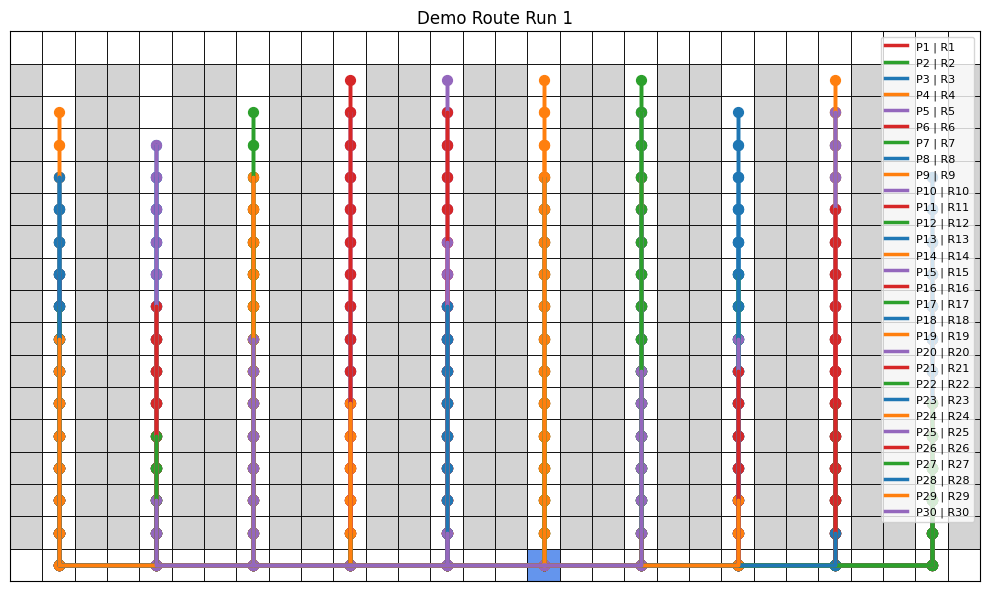


Generated orders for run 2:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A10_06'),
              Item(sku='S1_2', slot='A1_02'),
              Item(sku='S1_3', slot='A4_01')],
       size=3),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A8_02')], size=1),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A7_04'),
              Item(sku='S3_2', slot='A1_09'),
              Item(sku='S3_3', slot='A6_07')],
       size=3),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A7_12'), Item(sku='S4_2', slot='A6_05')],
       size=2),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A1_06'),
              Item(sku='S5_2', slot='A10_05'),
              Item(sku='S5_3', slot='A9_02'),
              Item(sku='S5_4', slot='A8_04')],
       size=4),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A4_14')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A2_11'), Item(sku='S7_2', slot='A7_14')],
       size=2),
 Order(order_id=

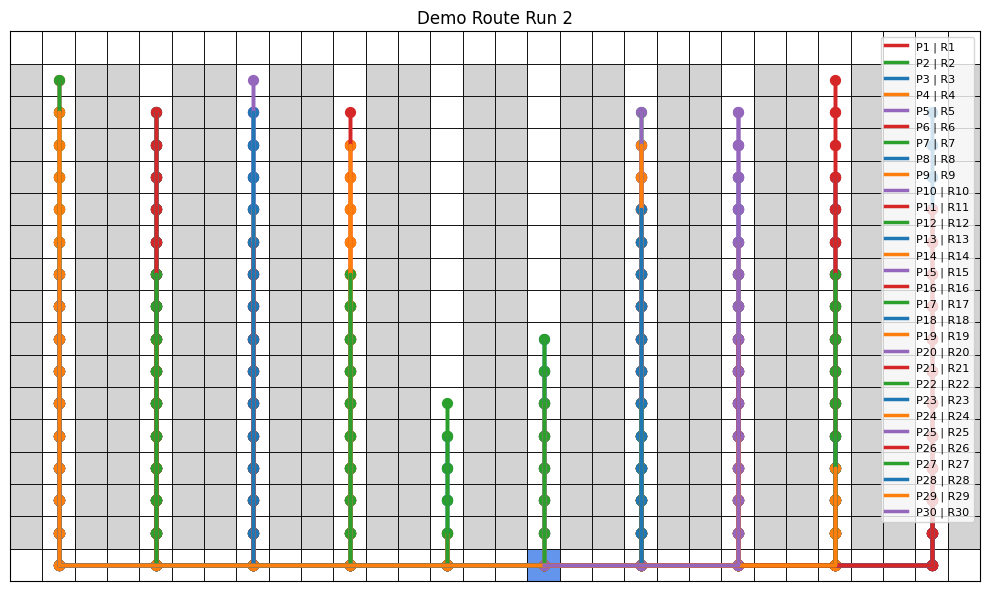


Generated orders for run 3:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A4_12'), Item(sku='S1_2', slot='A6_03')],
       size=2),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A4_02'),
              Item(sku='S2_2', slot='A6_15'),
              Item(sku='S2_3', slot='A3_09'),
              Item(sku='S2_4', slot='A6_04'),
              Item(sku='S2_5', slot='A1_02')],
       size=5),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A3_10')], size=1),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A9_10'),
              Item(sku='S4_2', slot='A8_02'),
              Item(sku='S4_3', slot='A2_11'),
              Item(sku='S4_4', slot='A5_06')],
       size=4),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A3_11'),
              Item(sku='S5_2', slot='A9_06'),
              Item(sku='S5_3', slot='A4_03')],
       size=3),
 Order(order_id='O6',
       items=[Item(sku='S6_1', slot='A3_07'),
              Item(sku='S6_2', slot='A1_13'),


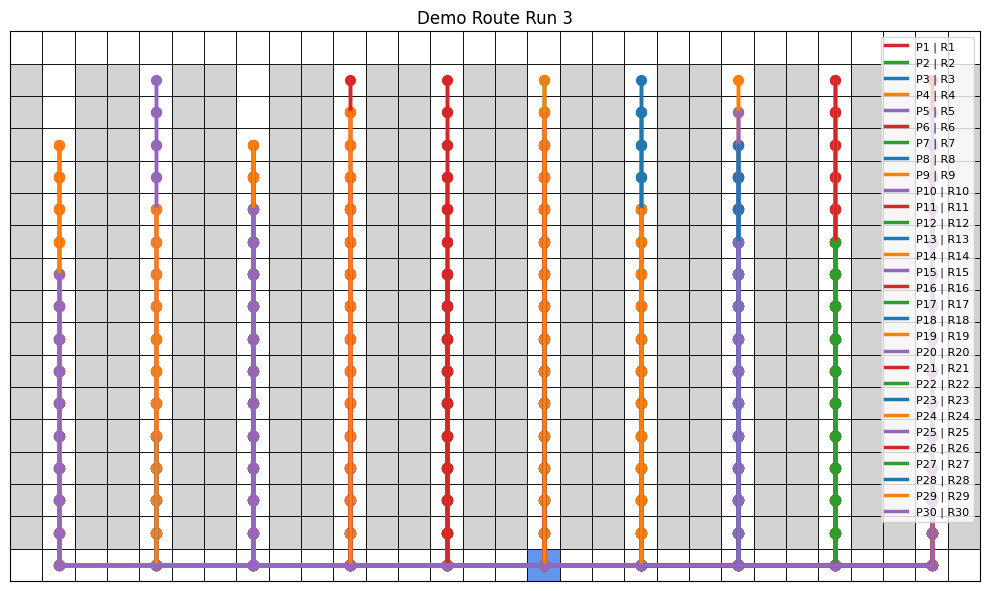


Generated orders for run 4:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A2_01'),
              Item(sku='S1_2', slot='A10_13'),
              Item(sku='S1_3', slot='A8_12'),
              Item(sku='S1_4', slot='A5_04'),
              Item(sku='S1_5', slot='A3_15')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A9_02'),
              Item(sku='S2_2', slot='A4_14'),
              Item(sku='S2_3', slot='A3_11'),
              Item(sku='S2_4', slot='A3_05')],
       size=4),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A9_05'),
              Item(sku='S3_2', slot='A2_08'),
              Item(sku='S3_3', slot='A6_01'),
              Item(sku='S3_4', slot='A10_03'),
              Item(sku='S3_5', slot='A3_07'),
              Item(sku='S3_6', slot='A7_02')],
       size=6),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A9_08'), Item(sku='S4_2', slot='A7_09')],
       size=2),
 Order(order_id='O5', items=[Item(sku='S5_1',

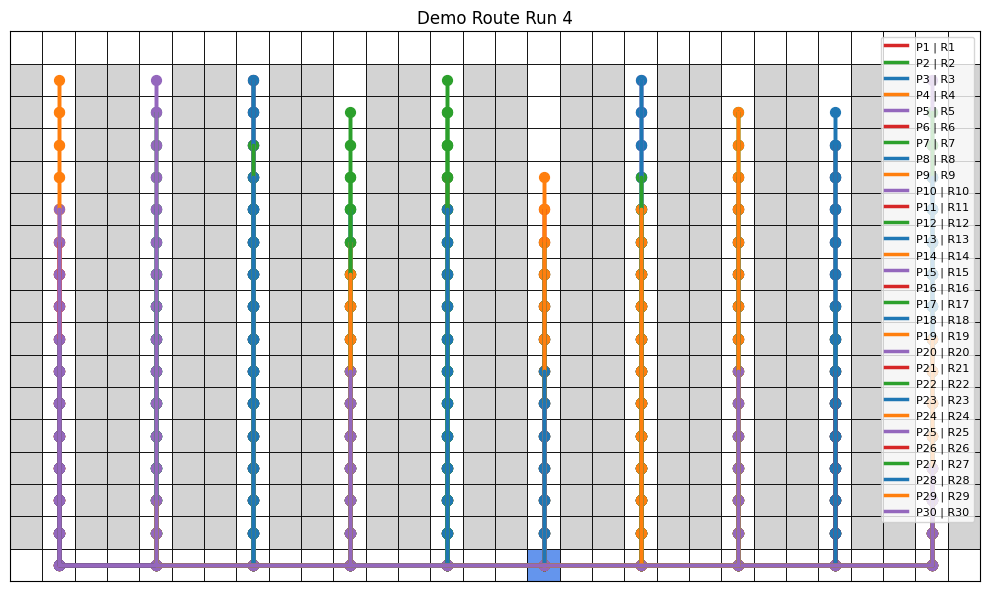


Generated orders for run 5:
[Order(order_id='O1', items=[Item(sku='S1_1', slot='A10_14')], size=1),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A2_11'),
              Item(sku='S2_2', slot='A1_07'),
              Item(sku='S2_3', slot='A1_08'),
              Item(sku='S2_4', slot='A5_09'),
              Item(sku='S2_5', slot='A4_07')],
       size=5),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A4_14'),
              Item(sku='S3_2', slot='A6_02'),
              Item(sku='S3_3', slot='A6_05'),
              Item(sku='S3_4', slot='A7_08')],
       size=4),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A6_06')], size=1),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A10_02'),
              Item(sku='S5_2', slot='A3_02'),
              Item(sku='S5_3', slot='A7_07')],
       size=3),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A2_09')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A7_05'),
              Item(

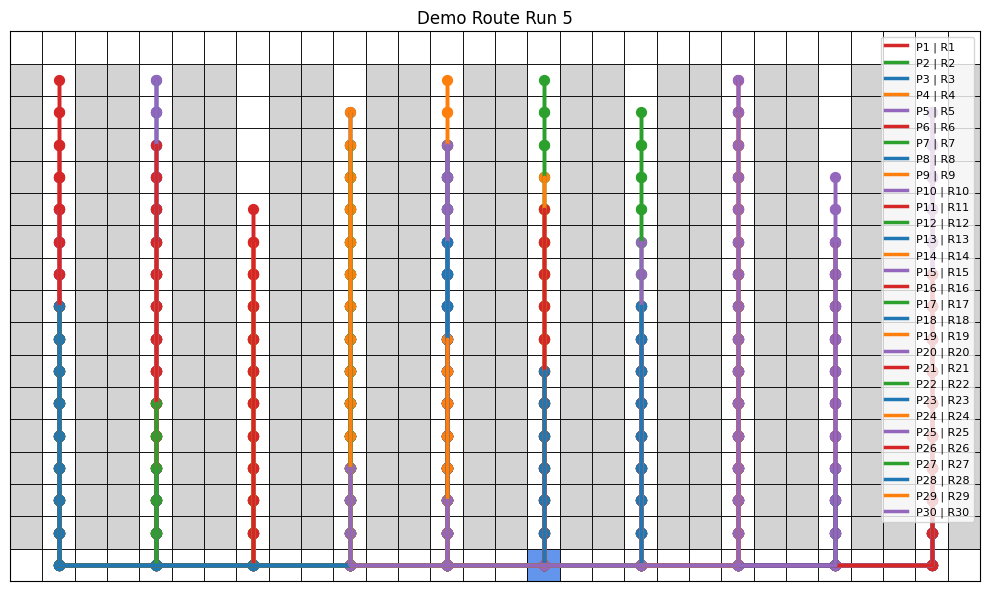


Generated orders for run 6:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A7_14'), Item(sku='S1_2', slot='A9_11')],
       size=2),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A3_05'),
              Item(sku='S2_2', slot='A9_04'),
              Item(sku='S2_3', slot='A1_08')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A6_07'), Item(sku='S3_2', slot='A10_04')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A10_13'),
              Item(sku='S4_2', slot='A10_08'),
              Item(sku='S4_3', slot='A6_02')],
       size=3),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A2_14')], size=1),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A5_15')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A3_02'),
              Item(sku='S7_2', slot='A8_08'),
              Item(sku='S7_3', slot='A3_13')],
       size=3),
 Order(order_id='O8',
       items=[Item(sku='S8_1', slot='A9

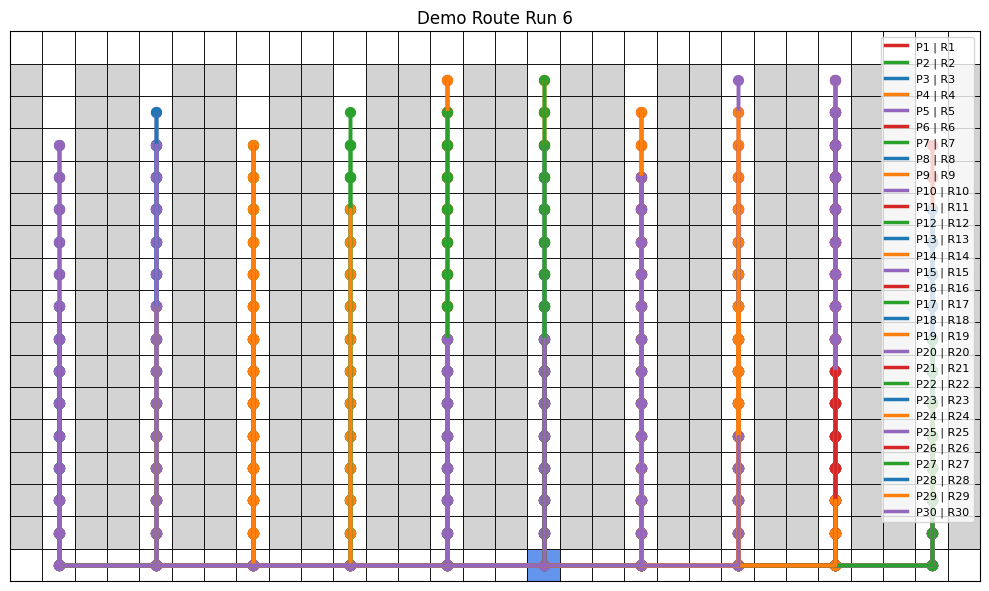


Generated orders for run 7:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A9_14'),
              Item(sku='S1_2', slot='A5_10'),
              Item(sku='S1_3', slot='A1_12'),
              Item(sku='S1_4', slot='A7_13'),
              Item(sku='S1_5', slot='A4_13')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A4_15'),
              Item(sku='S2_2', slot='A2_14'),
              Item(sku='S2_3', slot='A10_06')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A3_05'), Item(sku='S3_2', slot='A5_11')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A4_15'),
              Item(sku='S4_2', slot='A3_06'),
              Item(sku='S4_3', slot='A9_04'),
              Item(sku='S4_4', slot='A8_13'),
              Item(sku='S4_5', slot='A3_05')],
       size=5),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A5_07')], size=1),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A5_07')], size=

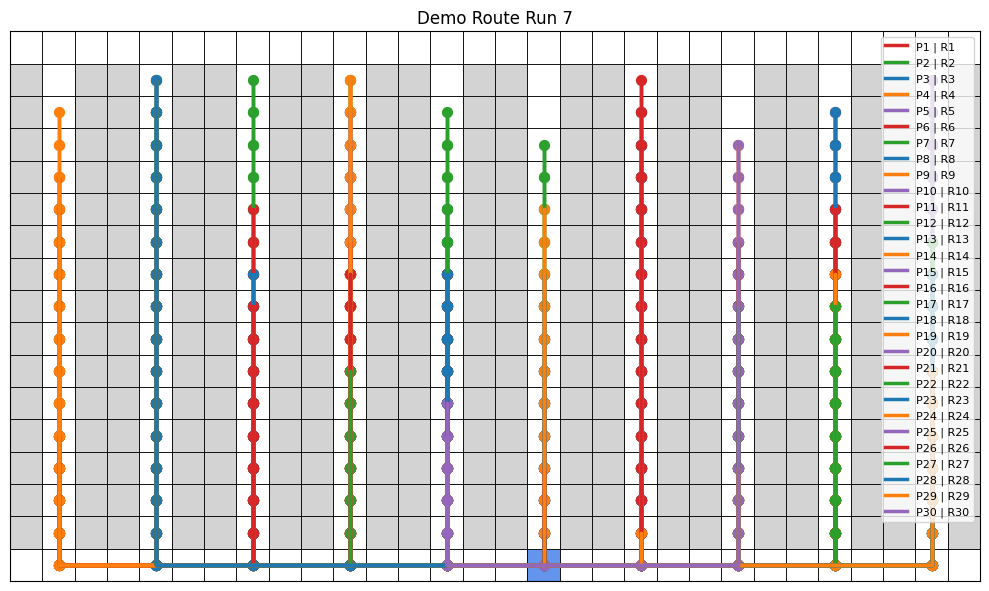


Generated orders for run 8:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A8_04'),
              Item(sku='S1_2', slot='A5_10'),
              Item(sku='S1_3', slot='A8_08'),
              Item(sku='S1_4', slot='A8_13'),
              Item(sku='S1_5', slot='A1_06')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A5_02'),
              Item(sku='S2_2', slot='A10_14'),
              Item(sku='S2_3', slot='A6_12')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A6_12'), Item(sku='S3_2', slot='A10_01')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A2_13'),
              Item(sku='S4_2', slot='A10_08'),
              Item(sku='S4_3', slot='A4_09'),
              Item(sku='S4_4', slot='A7_02'),
              Item(sku='S4_5', slot='A1_06'),
              Item(sku='S4_6', slot='A8_02')],
       size=6),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A7_05')], size=1),
 Order(order_id='O6

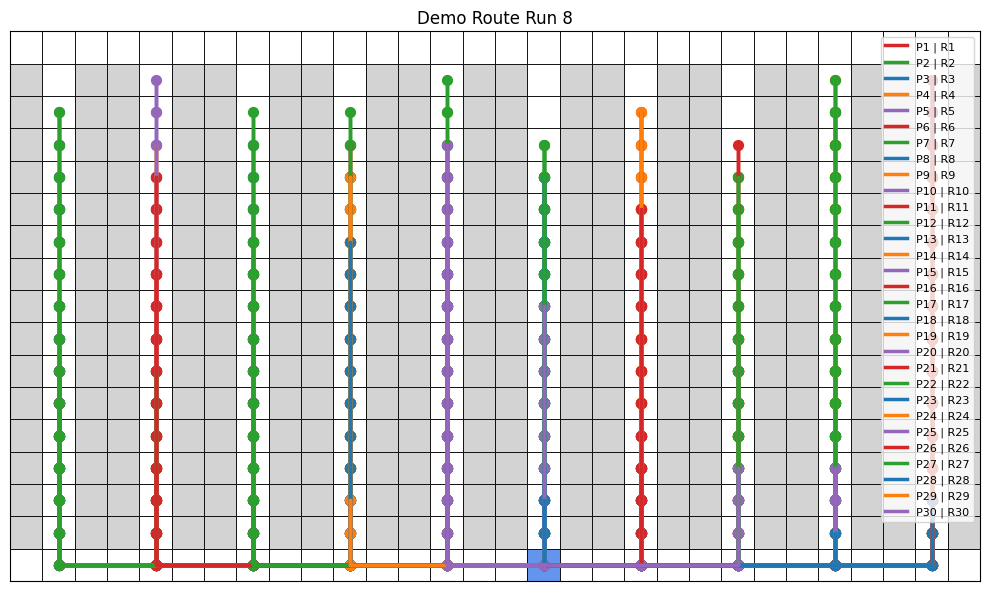


Generated orders for run 9:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A7_06'),
              Item(sku='S1_2', slot='A9_11'),
              Item(sku='S1_3', slot='A2_08')],
       size=3),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A5_14'),
              Item(sku='S2_2', slot='A1_05'),
              Item(sku='S2_3', slot='A7_10'),
              Item(sku='S2_4', slot='A3_02')],
       size=4),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A10_10'),
              Item(sku='S3_2', slot='A2_11'),
              Item(sku='S3_3', slot='A3_14')],
       size=3),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A10_07'), Item(sku='S4_2', slot='A8_09')],
       size=2),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A4_07'),
              Item(sku='S5_2', slot='A4_13'),
              Item(sku='S5_3', slot='A10_05'),
              Item(sku='S5_4', slot='A1_14')],
       size=4),
 Order(order_id='O6',
       items=[Item(sku='S6_1'

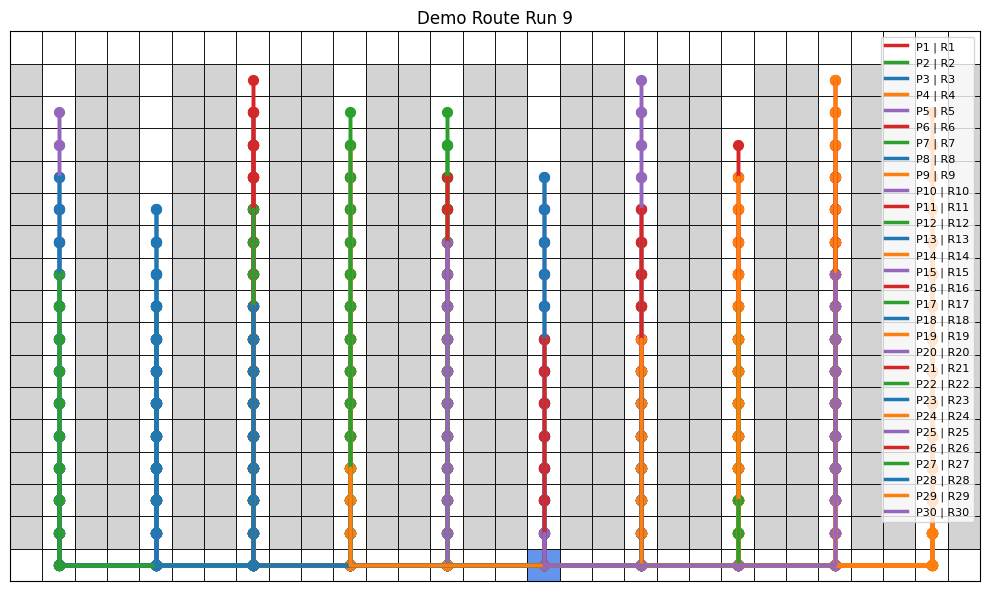


Generated orders for run 10:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A3_10'),
              Item(sku='S1_2', slot='A7_15'),
              Item(sku='S1_3', slot='A2_01'),
              Item(sku='S1_4', slot='A3_14')],
       size=4),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A6_04')], size=1),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A10_05')], size=1),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A5_04')], size=1),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A5_07'),
              Item(sku='S5_2', slot='A4_07'),
              Item(sku='S5_3', slot='A8_11'),
              Item(sku='S5_4', slot='A3_14')],
       size=4),
 Order(order_id='O6',
       items=[Item(sku='S6_1', slot='A10_13'),
              Item(sku='S6_2', slot='A7_13'),
              Item(sku='S6_3', slot='A5_04'),
              Item(sku='S6_4', slot='A9_08'),
              Item(sku='S6_5', slot='A10_02'),
              Item(sku='S6_6', slot='A10_09')],
       s

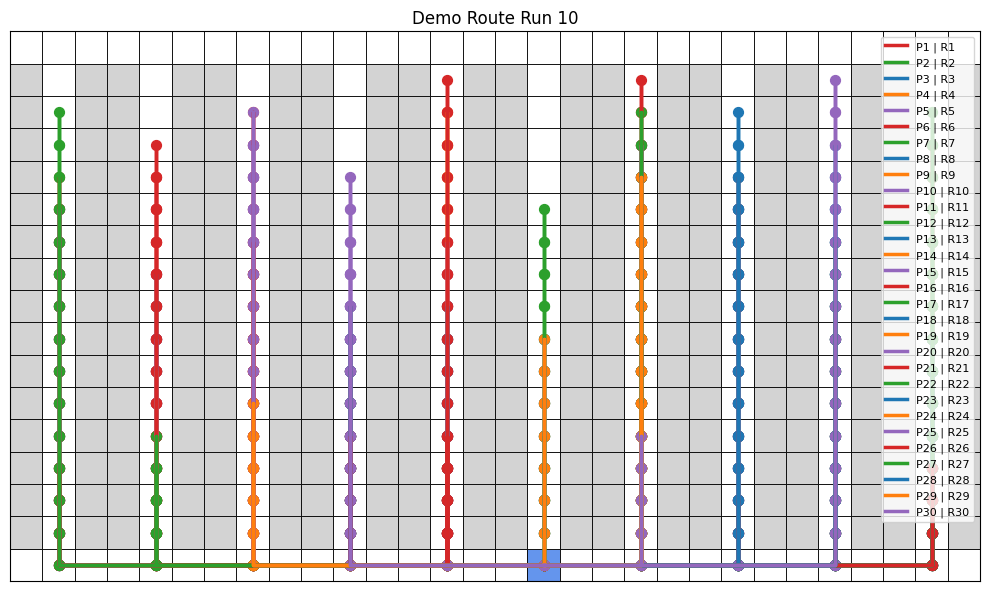


Average distance over 10 runs: 2477.3 m
Average travel time (s): 2064.416666666667 s
Average makespan (s): 145.83333333333334


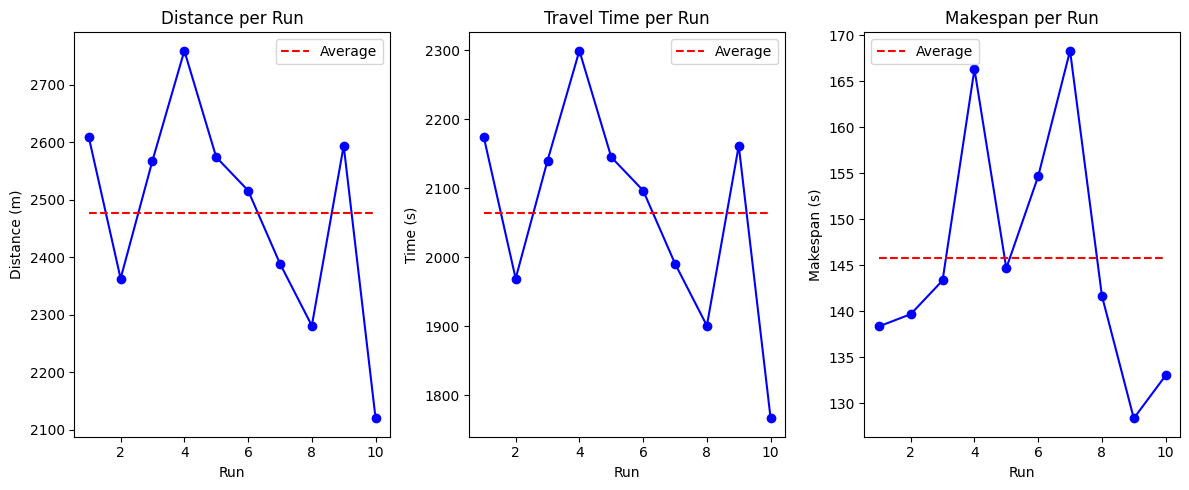

In [ ]:
def main(runs) -> None:
    """Demonstrate warehouse functionality."""
    simple_warehouse = Warehouse(
        num_aisles=10,
        slots_per_side=15,
        aisle_length_m=15.0,
        aisle_spacing_m=3.0,
        slot_pitch_m=1.0,
        io_node="F6",
    )
    required_slots = []
    solution = []
    distance = []
    travel_time = []
    makespan = []

    print("Grid dimensions (rows, cols):", simple_warehouse.grid_dimensions)

    print("\nGrid representation of warehouse:")
    print(simple_warehouse.grid_repr)

    print("\nWarehouse nodes DataFrame:")
    print(simple_warehouse.node_df)

    print("\nAdjacency matrix:")
    print(simple_warehouse.adjacency_matrix)

    print("\nAdjacency dictionary:")
    pprint(simple_warehouse.adjacency_dict)

    for run in range(runs):
        orders = simple_warehouse.generate_orders(
            num_orders=30, max_items_per_order=6, seed=123 + run
        )

        print(f"\nGenerated orders for run {run + 1}:")
        pprint(orders)

        # Required slots
        required = get_required_slots_for_orders([order.order_id for order in orders], orders)
        required_slots.append(required)
        print("\nRequired slots for all orders:", required)

        print("\nGraph representation of warehouse:")
        print(simple_warehouse.generate_layout_text(spacing=6))

        print("\nSlot dict:")
        pprint(simple_warehouse.slot_dict)

        # Generate a demo route
        sol = simple_warehouse.generate_solution(orders, policy=policy_single_order_picking, bin_size=20)
        solution.append(sol)
        print("\nGenerated route path:")
        pprint(sol)

        is_valid, message = simple_warehouse.validate_solution(sol, orders)
        print("Route valid?", is_valid, "-", message)

        simple_warehouse.plot_warehouse_routes(sol, title=f"Demo Route Run {run + 1}")

        # Compute metrics
        distance.append(simple_warehouse.calculate_solution_distance(sol))
        travel_time.append(simple_warehouse.calculate_solution_travel_time(sol, speed_mps=1.2))
        makespan.append(simple_warehouse.calculate_solution_makespan(sol, orders, speed_mps=1.2, pick_time_sec=3.0))

    # Average metrics
    average_distance = sum(distance) / len(distance)
    average_travel_time = sum(travel_time) / len(travel_time)
    average_makespan = sum(makespan) / len(makespan)


    print("\nAverage distance over", runs, "runs:", average_distance, "m")
    print("Average travel time (s):", average_travel_time, "s")
    print("Average makespan (s):", average_makespan)
    
    # Plot metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, runs + 1), distance, marker='o', color='blue')
    plt.plot(range(1, runs + 1), [average_distance] * runs, marker='', color='red', linestyle='--', label='Average')
    plt.title('Distance per Run')
    plt.xlabel('Run')
    plt.ylabel('Distance (m)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, runs + 1), travel_time, marker='o', color='blue')
    plt.plot(range(1, runs + 1), [average_travel_time] * runs, marker='', color='red', linestyle='--', label='Average')
    plt.title('Travel Time per Run')
    plt.xlabel('Run')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, runs + 1), makespan, marker='o', color='blue')
    plt.plot(range(1, runs + 1), [average_makespan] * runs, marker='', color='red', linestyle='--', label='Average')
    plt.title('Makespan per Run')
    plt.xlabel('Run')
    plt.ylabel('Makespan (s)')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main(10)


# Run Batch order picking

Grid dimensions (rows, cols): (17, 30)

Grid representation of warehouse:
 F0_0  F0_1  F0_2  F0_3  F0_4  F0_5  F0_6  F0_7  F0_8  F0_9 F0_10 F0_11 F0_12 F0_13 F0_14 F0_15 F0_16 F0_17 F0_18 F0_19 F0_20 F0_21 F0_22 F0_23 F0_24 F0_25 F0_26 F0_27 F0_28 F0_29 
 S1_0  A1_1  S1_2  S1_3  A1_4  S1_5  S1_6  A1_7  S1_8  S1_9 A1_10 S1_11 S1_12 A1_13 S1_14 S1_15 A1_16 S1_17 S1_18 A1_19 S1_20 S1_21 A1_22 S1_23 S1_24 A1_25 S1_26 S1_27 A1_28 S1_29 
 S2_0  A2_1  S2_2  S2_3  A2_4  S2_5  S2_6  A2_7  S2_8  S2_9 A2_10 S2_11 S2_12 A2_13 S2_14 S2_15 A2_16 S2_17 S2_18 A2_19 S2_20 S2_21 A2_22 S2_23 S2_24 A2_25 S2_26 S2_27 A2_28 S2_29 
 S3_0  A3_1  S3_2  S3_3  A3_4  S3_5  S3_6  A3_7  S3_8  S3_9 A3_10 S3_11 S3_12 A3_13 S3_14 S3_15 A3_16 S3_17 S3_18 A3_19 S3_20 S3_21 A3_22 S3_23 S3_24 A3_25 S3_26 S3_27 A3_28 S3_29 
 S4_0  A4_1  S4_2  S4_3  A4_4  S4_5  S4_6  A4_7  S4_8  S4_9 A4_10 S4_11 S4_12 A4_13 S4_14 S4_15 A4_16 S4_17 S4_18 A4_19 S4_20 S4_21 A4_22 S4_23 S4_24 A4_25 S4_26 S4_27 A4_28 S4_29 
 S5_0  A5_1  S5_2  S5

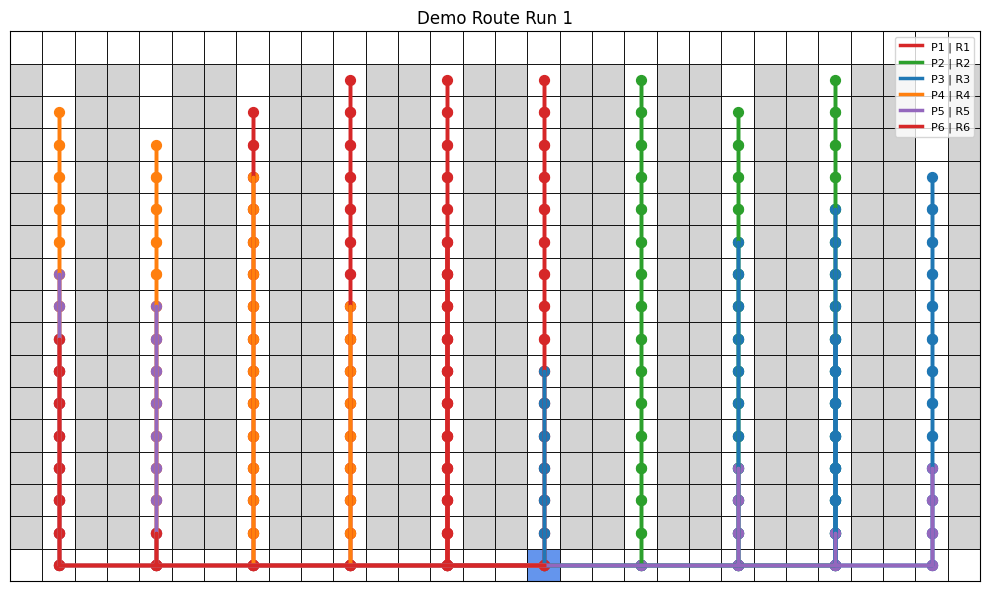


Generated orders for run 2:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A10_06'),
              Item(sku='S1_2', slot='A1_02'),
              Item(sku='S1_3', slot='A4_01')],
       size=3),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A8_02')], size=1),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A7_04'),
              Item(sku='S3_2', slot='A1_09'),
              Item(sku='S3_3', slot='A6_07')],
       size=3),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A7_12'), Item(sku='S4_2', slot='A6_05')],
       size=2),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A1_06'),
              Item(sku='S5_2', slot='A10_05'),
              Item(sku='S5_3', slot='A9_02'),
              Item(sku='S5_4', slot='A8_04')],
       size=4),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A4_14')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A2_11'), Item(sku='S7_2', slot='A7_14')],
       size=2),
 Order(order_id=

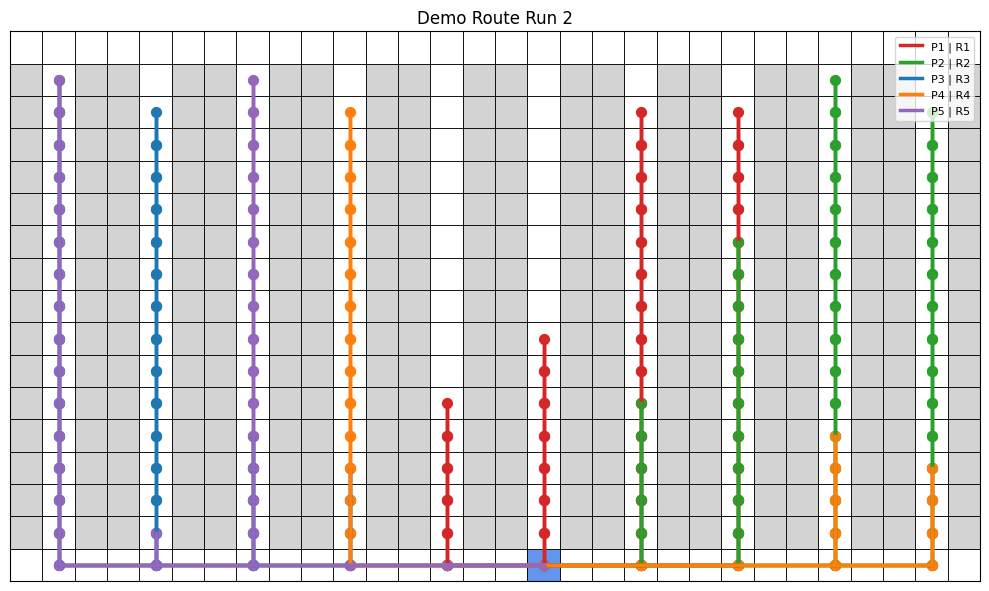


Generated orders for run 3:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A4_12'), Item(sku='S1_2', slot='A6_03')],
       size=2),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A4_02'),
              Item(sku='S2_2', slot='A6_15'),
              Item(sku='S2_3', slot='A3_09'),
              Item(sku='S2_4', slot='A6_04'),
              Item(sku='S2_5', slot='A1_02')],
       size=5),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A3_10')], size=1),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A9_10'),
              Item(sku='S4_2', slot='A8_02'),
              Item(sku='S4_3', slot='A2_11'),
              Item(sku='S4_4', slot='A5_06')],
       size=4),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A3_11'),
              Item(sku='S5_2', slot='A9_06'),
              Item(sku='S5_3', slot='A4_03')],
       size=3),
 Order(order_id='O6',
       items=[Item(sku='S6_1', slot='A3_07'),
              Item(sku='S6_2', slot='A1_13'),


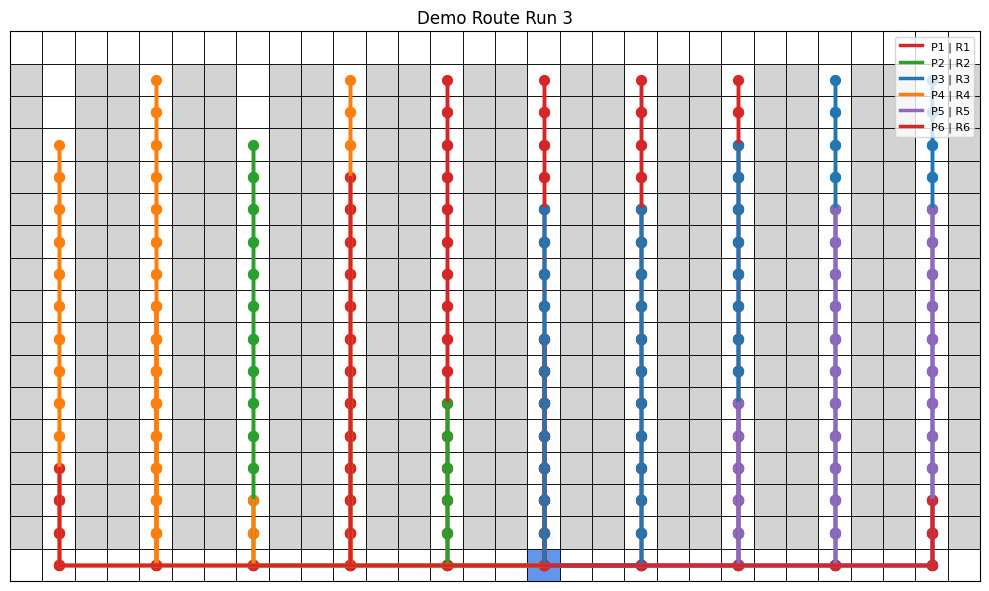


Generated orders for run 4:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A2_01'),
              Item(sku='S1_2', slot='A10_13'),
              Item(sku='S1_3', slot='A8_12'),
              Item(sku='S1_4', slot='A5_04'),
              Item(sku='S1_5', slot='A3_15')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A9_02'),
              Item(sku='S2_2', slot='A4_14'),
              Item(sku='S2_3', slot='A3_11'),
              Item(sku='S2_4', slot='A3_05')],
       size=4),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A9_05'),
              Item(sku='S3_2', slot='A2_08'),
              Item(sku='S3_3', slot='A6_01'),
              Item(sku='S3_4', slot='A10_03'),
              Item(sku='S3_5', slot='A3_07'),
              Item(sku='S3_6', slot='A7_02')],
       size=6),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A9_08'), Item(sku='S4_2', slot='A7_09')],
       size=2),
 Order(order_id='O5', items=[Item(sku='S5_1',

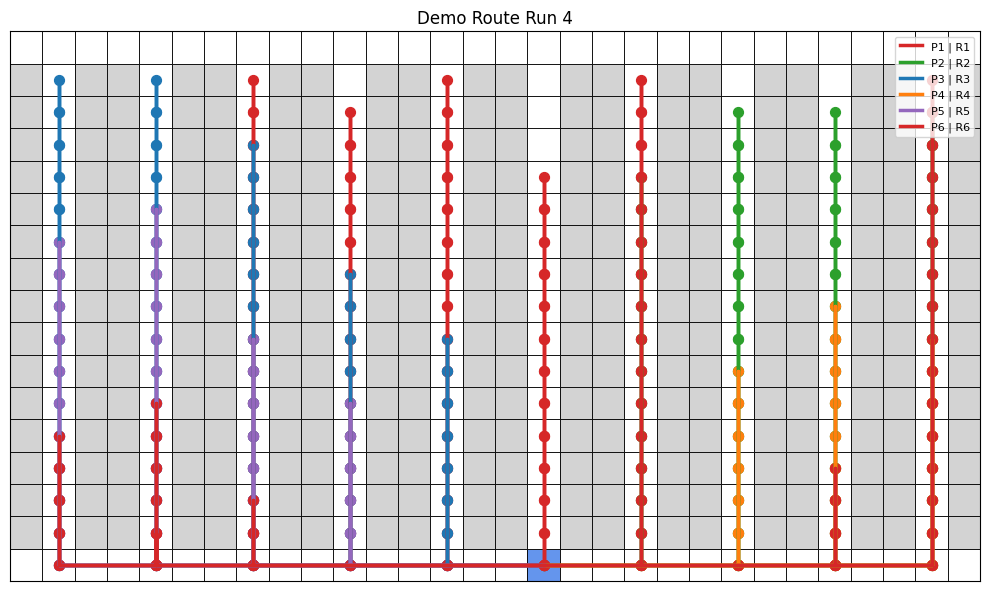


Generated orders for run 5:
[Order(order_id='O1', items=[Item(sku='S1_1', slot='A10_14')], size=1),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A2_11'),
              Item(sku='S2_2', slot='A1_07'),
              Item(sku='S2_3', slot='A1_08'),
              Item(sku='S2_4', slot='A5_09'),
              Item(sku='S2_5', slot='A4_07')],
       size=5),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A4_14'),
              Item(sku='S3_2', slot='A6_02'),
              Item(sku='S3_3', slot='A6_05'),
              Item(sku='S3_4', slot='A7_08')],
       size=4),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A6_06')], size=1),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A10_02'),
              Item(sku='S5_2', slot='A3_02'),
              Item(sku='S5_3', slot='A7_07')],
       size=3),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A2_09')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A7_05'),
              Item(

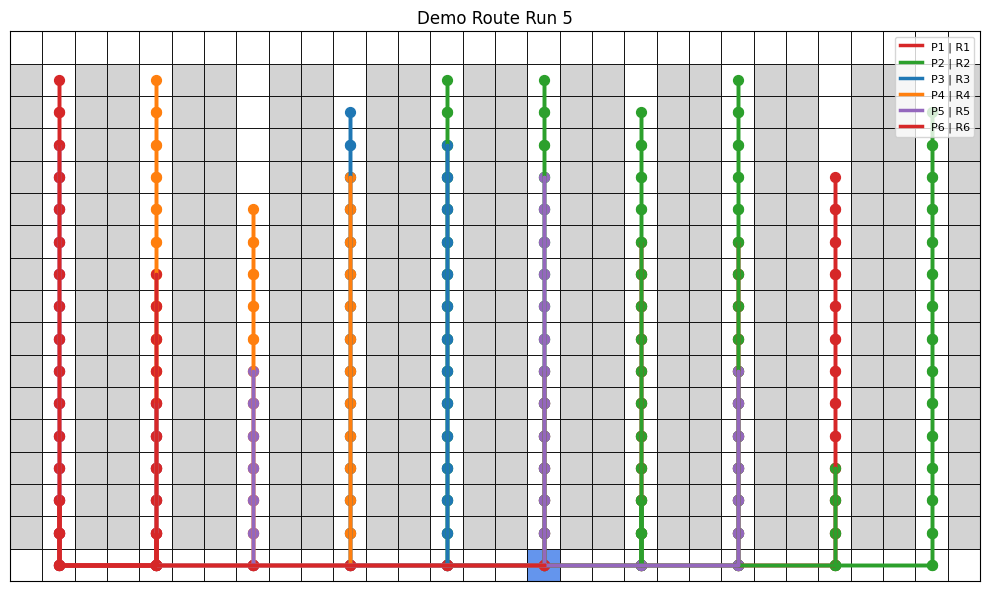


Generated orders for run 6:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A7_14'), Item(sku='S1_2', slot='A9_11')],
       size=2),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A3_05'),
              Item(sku='S2_2', slot='A9_04'),
              Item(sku='S2_3', slot='A1_08')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A6_07'), Item(sku='S3_2', slot='A10_04')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A10_13'),
              Item(sku='S4_2', slot='A10_08'),
              Item(sku='S4_3', slot='A6_02')],
       size=3),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A2_14')], size=1),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A5_15')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A3_02'),
              Item(sku='S7_2', slot='A8_08'),
              Item(sku='S7_3', slot='A3_13')],
       size=3),
 Order(order_id='O8',
       items=[Item(sku='S8_1', slot='A9

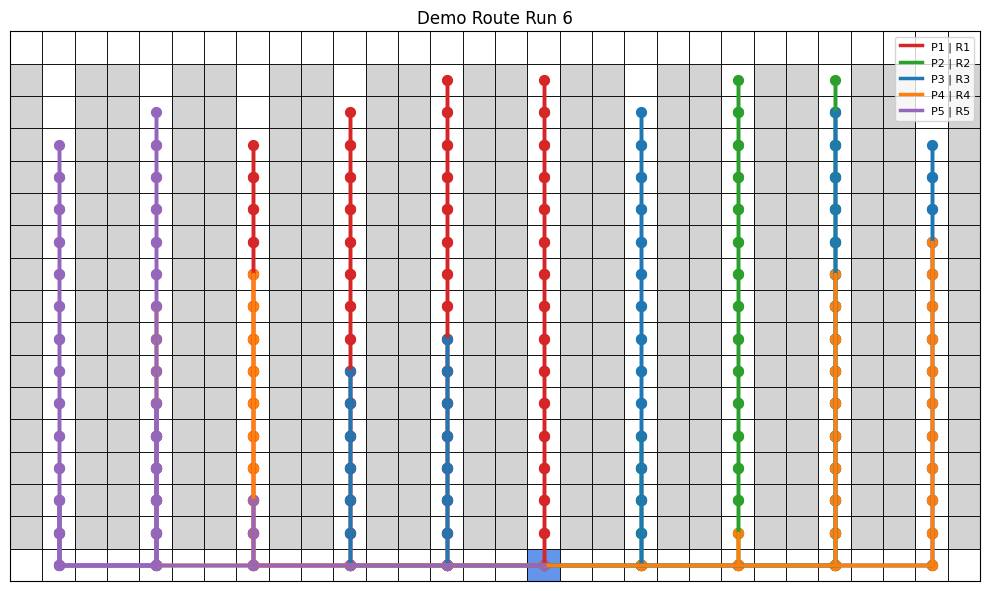


Generated orders for run 7:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A9_14'),
              Item(sku='S1_2', slot='A5_10'),
              Item(sku='S1_3', slot='A1_12'),
              Item(sku='S1_4', slot='A7_13'),
              Item(sku='S1_5', slot='A4_13')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A4_15'),
              Item(sku='S2_2', slot='A2_14'),
              Item(sku='S2_3', slot='A10_06')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A3_05'), Item(sku='S3_2', slot='A5_11')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A4_15'),
              Item(sku='S4_2', slot='A3_06'),
              Item(sku='S4_3', slot='A9_04'),
              Item(sku='S4_4', slot='A8_13'),
              Item(sku='S4_5', slot='A3_05')],
       size=5),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A5_07')], size=1),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A5_07')], size=

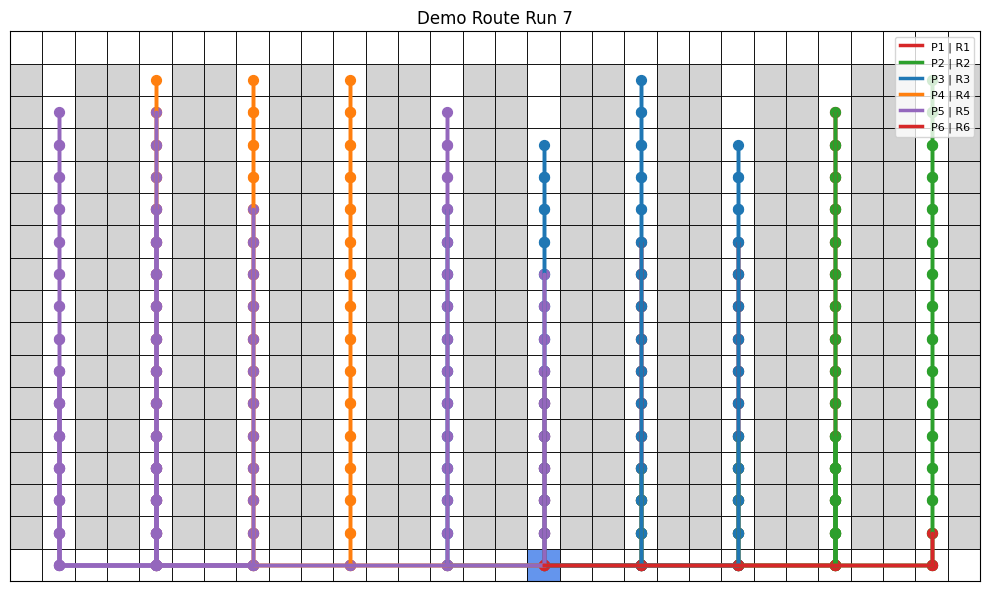


Generated orders for run 8:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A8_04'),
              Item(sku='S1_2', slot='A5_10'),
              Item(sku='S1_3', slot='A8_08'),
              Item(sku='S1_4', slot='A8_13'),
              Item(sku='S1_5', slot='A1_06')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A5_02'),
              Item(sku='S2_2', slot='A10_14'),
              Item(sku='S2_3', slot='A6_12')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A6_12'), Item(sku='S3_2', slot='A10_01')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A2_13'),
              Item(sku='S4_2', slot='A10_08'),
              Item(sku='S4_3', slot='A4_09'),
              Item(sku='S4_4', slot='A7_02'),
              Item(sku='S4_5', slot='A1_06'),
              Item(sku='S4_6', slot='A8_02')],
       size=6),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A7_05')], size=1),
 Order(order_id='O6

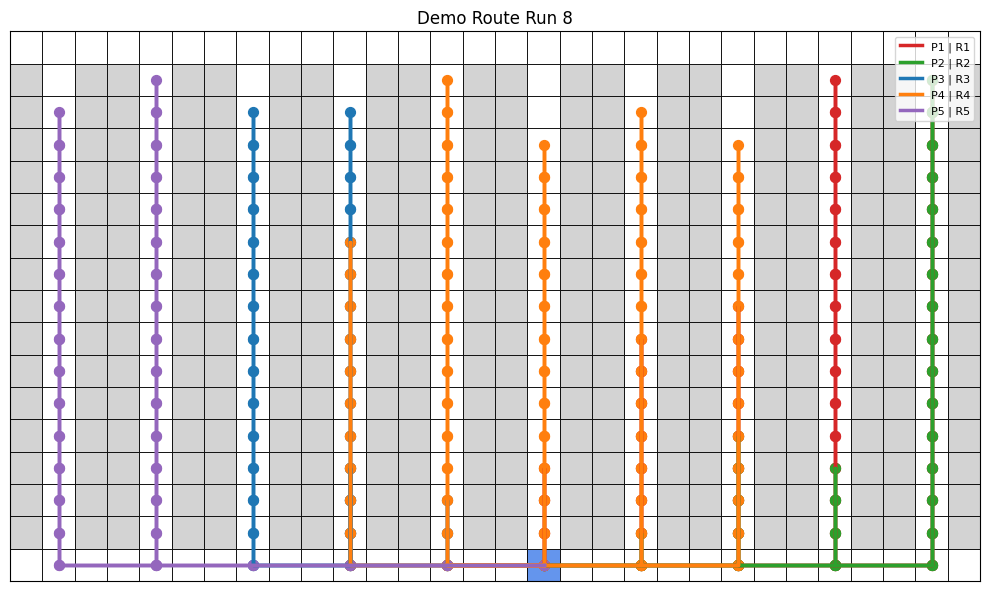


Generated orders for run 9:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A7_06'),
              Item(sku='S1_2', slot='A9_11'),
              Item(sku='S1_3', slot='A2_08')],
       size=3),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A5_14'),
              Item(sku='S2_2', slot='A1_05'),
              Item(sku='S2_3', slot='A7_10'),
              Item(sku='S2_4', slot='A3_02')],
       size=4),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A10_10'),
              Item(sku='S3_2', slot='A2_11'),
              Item(sku='S3_3', slot='A3_14')],
       size=3),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A10_07'), Item(sku='S4_2', slot='A8_09')],
       size=2),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A4_07'),
              Item(sku='S5_2', slot='A4_13'),
              Item(sku='S5_3', slot='A10_05'),
              Item(sku='S5_4', slot='A1_14')],
       size=4),
 Order(order_id='O6',
       items=[Item(sku='S6_1'

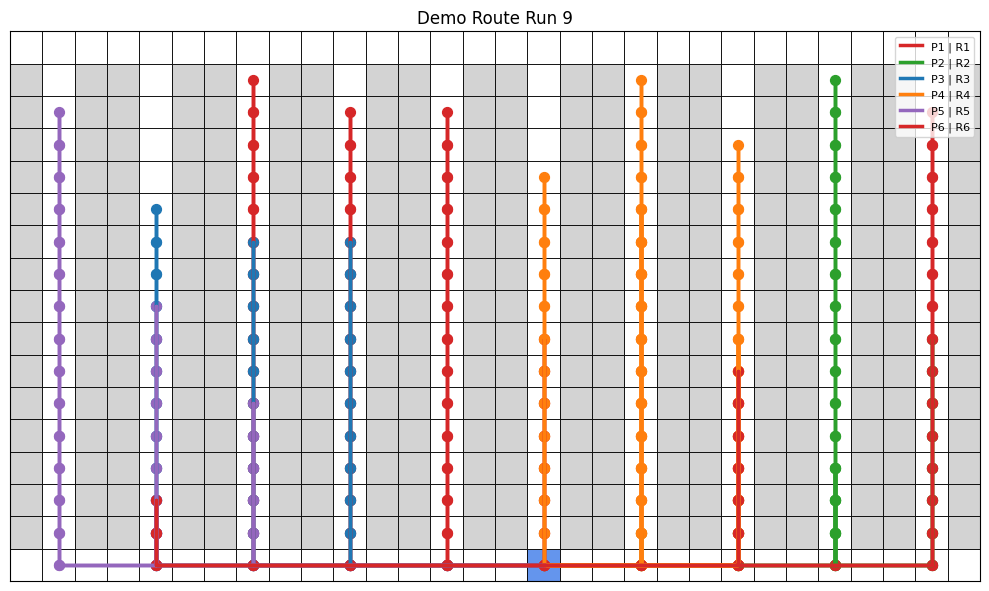


Generated orders for run 10:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A3_10'),
              Item(sku='S1_2', slot='A7_15'),
              Item(sku='S1_3', slot='A2_01'),
              Item(sku='S1_4', slot='A3_14')],
       size=4),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A6_04')], size=1),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A10_05')], size=1),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A5_04')], size=1),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A5_07'),
              Item(sku='S5_2', slot='A4_07'),
              Item(sku='S5_3', slot='A8_11'),
              Item(sku='S5_4', slot='A3_14')],
       size=4),
 Order(order_id='O6',
       items=[Item(sku='S6_1', slot='A10_13'),
              Item(sku='S6_2', slot='A7_13'),
              Item(sku='S6_3', slot='A5_04'),
              Item(sku='S6_4', slot='A9_08'),
              Item(sku='S6_5', slot='A10_02'),
              Item(sku='S6_6', slot='A10_09')],
       s

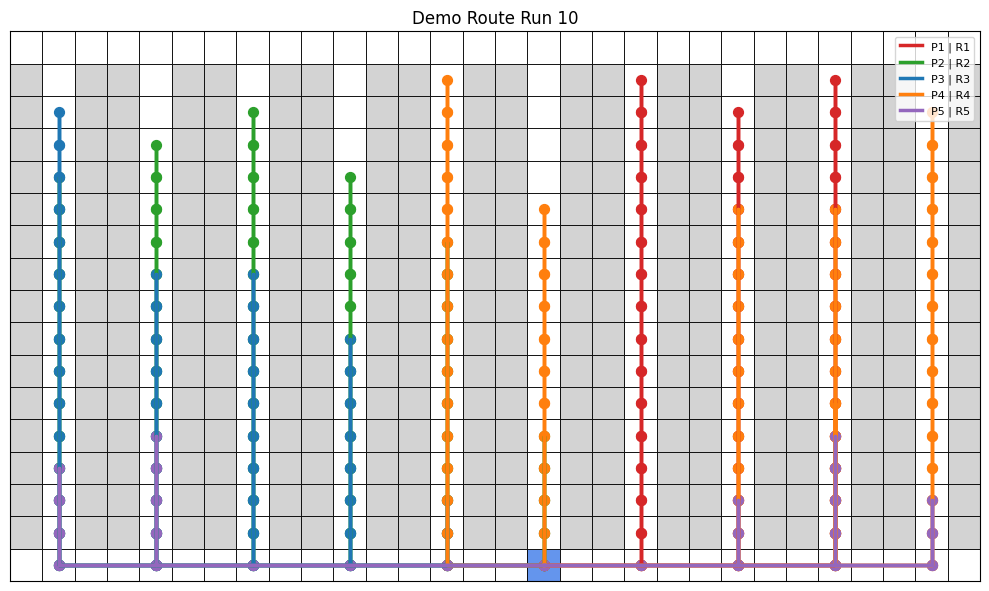


Average distance over 10 runs: 621.4 m
Average travel time (s): 517.8333333333334 s
Average makespan (s): 327.8


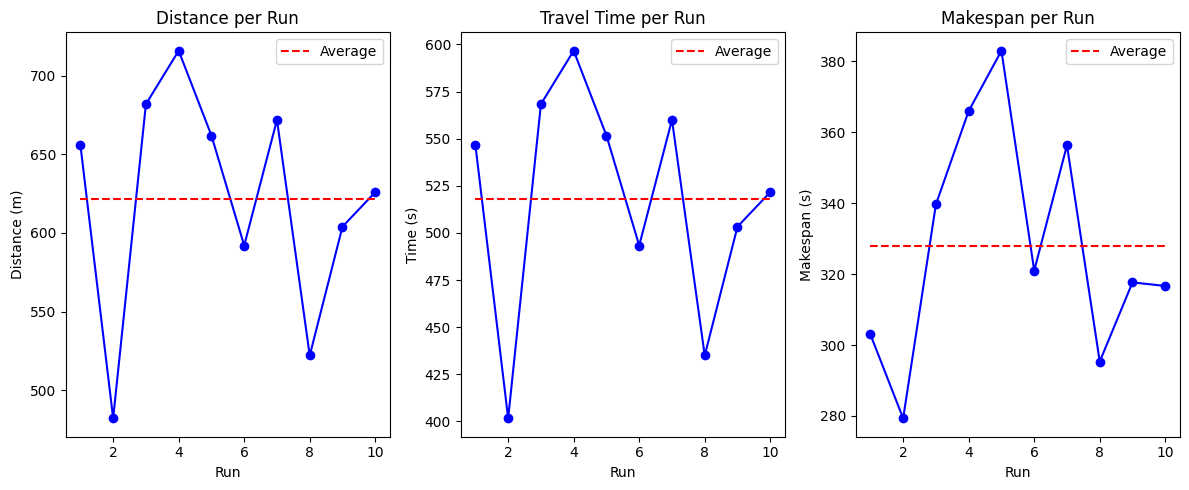

In [39]:
def main(runs) -> None:
    """Demonstrate warehouse functionality."""
    simple_warehouse = Warehouse(
        num_aisles=10,
        slots_per_side=15,
        aisle_length_m=15.0,
        aisle_spacing_m=3.0,
        slot_pitch_m=1.0,
        io_node="F6",
    )
    required_slots = []
    solution = []
    distance = []
    travel_time = []
    makespan = []

    print("Grid dimensions (rows, cols):", simple_warehouse.grid_dimensions)

    print("\nGrid representation of warehouse:")
    print(simple_warehouse.grid_repr)

    print("\nWarehouse nodes DataFrame:")
    print(simple_warehouse.node_df)

    print("\nAdjacency matrix:")
    print(simple_warehouse.adjacency_matrix)

    print("\nAdjacency dictionary:")
    pprint(simple_warehouse.adjacency_dict)

    for run in range(runs):
        orders = simple_warehouse.generate_orders(
            num_orders=30, max_items_per_order=6, seed=123 + run
        )

        print(f"\nGenerated orders for run {run + 1}:")
        pprint(orders)

        # Required slots
        required = get_required_slots_for_orders([order.order_id for order in orders], orders)
        required_slots.append(required)
        print("\nRequired slots for all orders:", required)

        print("\nGraph representation of warehouse:")
        print(simple_warehouse.generate_layout_text(spacing=6))

        print("\nSlot dict:")
        pprint(simple_warehouse.slot_dict)

        # Generate a demo route
        sol = simple_warehouse.generate_solution(orders, policy=policy_batch_order_picking, bin_size=20)
        solution.append(sol)
        print("\nGenerated route path:")
        pprint(sol)

        is_valid, message = simple_warehouse.validate_solution(sol, orders)
        print("Route valid?", is_valid, "-", message)

        simple_warehouse.plot_warehouse_routes(sol, title=f"Demo Route Run {run + 1}")

        # Compute metrics
        distance.append(simple_warehouse.calculate_solution_distance(sol))
        travel_time.append(simple_warehouse.calculate_solution_travel_time(sol, speed_mps=1.2))
        makespan.append(simple_warehouse.calculate_solution_makespan(sol, orders, speed_mps=1.2, pick_time_sec=3.0))

    # Average metrics
    average_distance = sum(distance) / len(distance)
    average_travel_time = sum(travel_time) / len(travel_time)
    average_makespan = sum(makespan) / len(makespan)

    print("\nAverage distance over", runs, "runs:", average_distance, "m")
    print("Average travel time (s):", average_travel_time, "s")
    print("Average makespan (s):", average_makespan)

    # Plot metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, runs + 1), distance, marker='o', color='blue')
    plt.plot(range(1, runs + 1), [average_distance] * runs, marker='', color='red', linestyle='--', label='Average')
    plt.title('Distance per Run')
    plt.xlabel('Run')
    plt.ylabel('Distance (m)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, runs + 1), travel_time, marker='o', color='blue')
    plt.plot(range(1, runs + 1), [average_travel_time] * runs, marker='', color='red', linestyle='--', label='Average')
    plt.title('Travel Time per Run')
    plt.xlabel('Run')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, runs + 1), makespan, marker='o', color='blue')
    plt.plot(range(1, runs + 1), [average_makespan] * runs, marker='', color='red', linestyle='--', label='Average')
    plt.title('Makespan per Run')
    plt.xlabel('Run')
    plt.ylabel('Makespan (s)')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main(10)


Grid dimensions (rows, cols): (17, 30)

Grid representation of warehouse:
 F0_0  F0_1  F0_2  F0_3  F0_4  F0_5  F0_6  F0_7  F0_8  F0_9 F0_10 F0_11 F0_12 F0_13 F0_14 F0_15 F0_16 F0_17 F0_18 F0_19 F0_20 F0_21 F0_22 F0_23 F0_24 F0_25 F0_26 F0_27 F0_28 F0_29 
 S1_0  A1_1  S1_2  S1_3  A1_4  S1_5  S1_6  A1_7  S1_8  S1_9 A1_10 S1_11 S1_12 A1_13 S1_14 S1_15 A1_16 S1_17 S1_18 A1_19 S1_20 S1_21 A1_22 S1_23 S1_24 A1_25 S1_26 S1_27 A1_28 S1_29 
 S2_0  A2_1  S2_2  S2_3  A2_4  S2_5  S2_6  A2_7  S2_8  S2_9 A2_10 S2_11 S2_12 A2_13 S2_14 S2_15 A2_16 S2_17 S2_18 A2_19 S2_20 S2_21 A2_22 S2_23 S2_24 A2_25 S2_26 S2_27 A2_28 S2_29 
 S3_0  A3_1  S3_2  S3_3  A3_4  S3_5  S3_6  A3_7  S3_8  S3_9 A3_10 S3_11 S3_12 A3_13 S3_14 S3_15 A3_16 S3_17 S3_18 A3_19 S3_20 S3_21 A3_22 S3_23 S3_24 A3_25 S3_26 S3_27 A3_28 S3_29 
 S4_0  A4_1  S4_2  S4_3  A4_4  S4_5  S4_6  A4_7  S4_8  S4_9 A4_10 S4_11 S4_12 A4_13 S4_14 S4_15 A4_16 S4_17 S4_18 A4_19 S4_20 S4_21 A4_22 S4_23 S4_24 A4_25 S4_26 S4_27 A4_28 S4_29 
 S5_0  A5_1  S5_2  S5

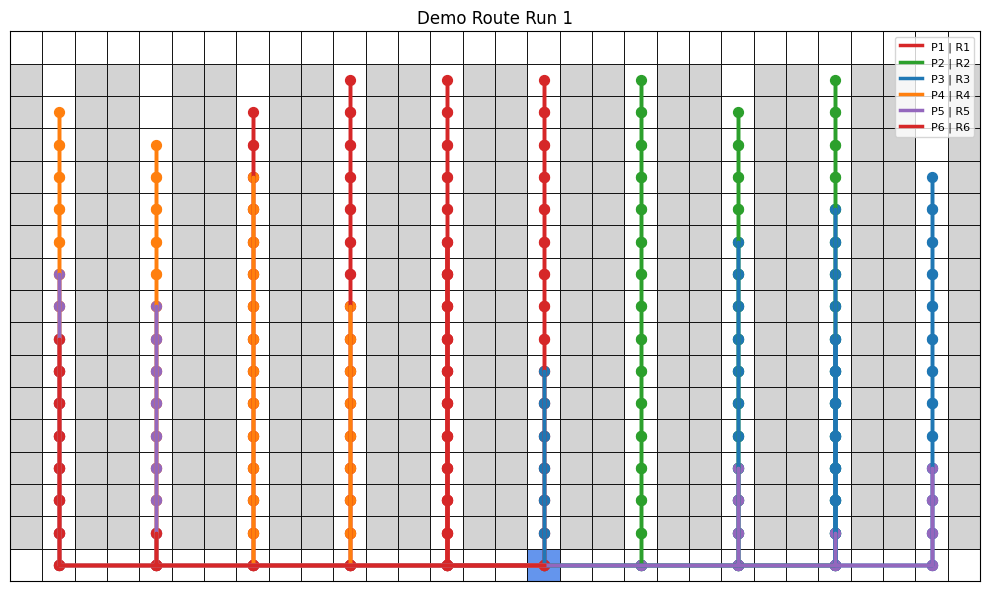


Generated orders for run 2:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A10_06'),
              Item(sku='S1_2', slot='A1_02'),
              Item(sku='S1_3', slot='A4_01')],
       size=3),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A8_02')], size=1),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A7_04'),
              Item(sku='S3_2', slot='A1_09'),
              Item(sku='S3_3', slot='A6_07')],
       size=3),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A7_12'), Item(sku='S4_2', slot='A6_05')],
       size=2),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A1_06'),
              Item(sku='S5_2', slot='A10_05'),
              Item(sku='S5_3', slot='A9_02'),
              Item(sku='S5_4', slot='A8_04')],
       size=4),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A4_14')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A2_11'), Item(sku='S7_2', slot='A7_14')],
       size=2),
 Order(order_id=

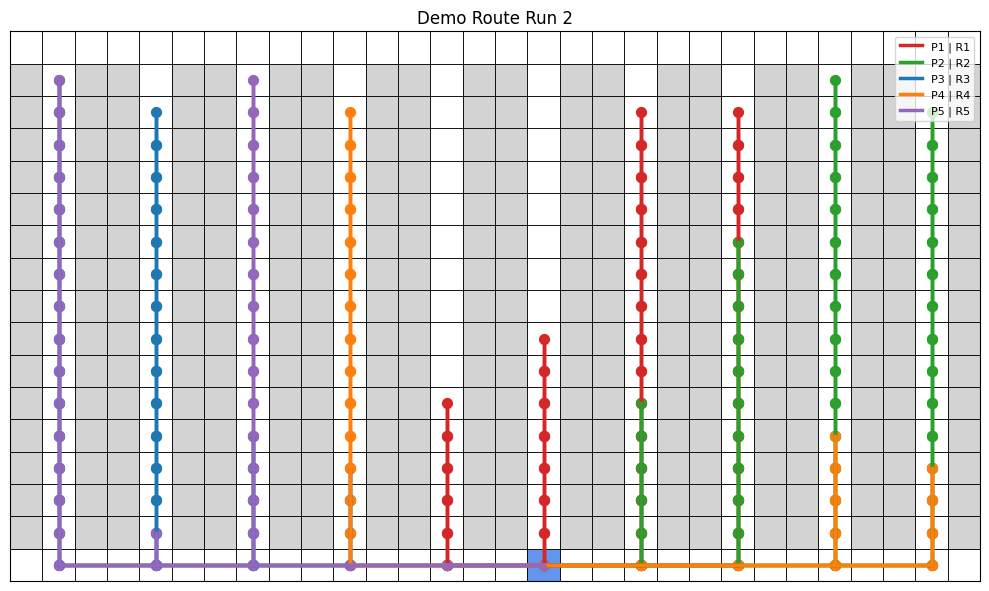


Generated orders for run 3:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A4_12'), Item(sku='S1_2', slot='A6_03')],
       size=2),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A4_02'),
              Item(sku='S2_2', slot='A6_15'),
              Item(sku='S2_3', slot='A3_09'),
              Item(sku='S2_4', slot='A6_04'),
              Item(sku='S2_5', slot='A1_02')],
       size=5),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A3_10')], size=1),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A9_10'),
              Item(sku='S4_2', slot='A8_02'),
              Item(sku='S4_3', slot='A2_11'),
              Item(sku='S4_4', slot='A5_06')],
       size=4),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A3_11'),
              Item(sku='S5_2', slot='A9_06'),
              Item(sku='S5_3', slot='A4_03')],
       size=3),
 Order(order_id='O6',
       items=[Item(sku='S6_1', slot='A3_07'),
              Item(sku='S6_2', slot='A1_13'),


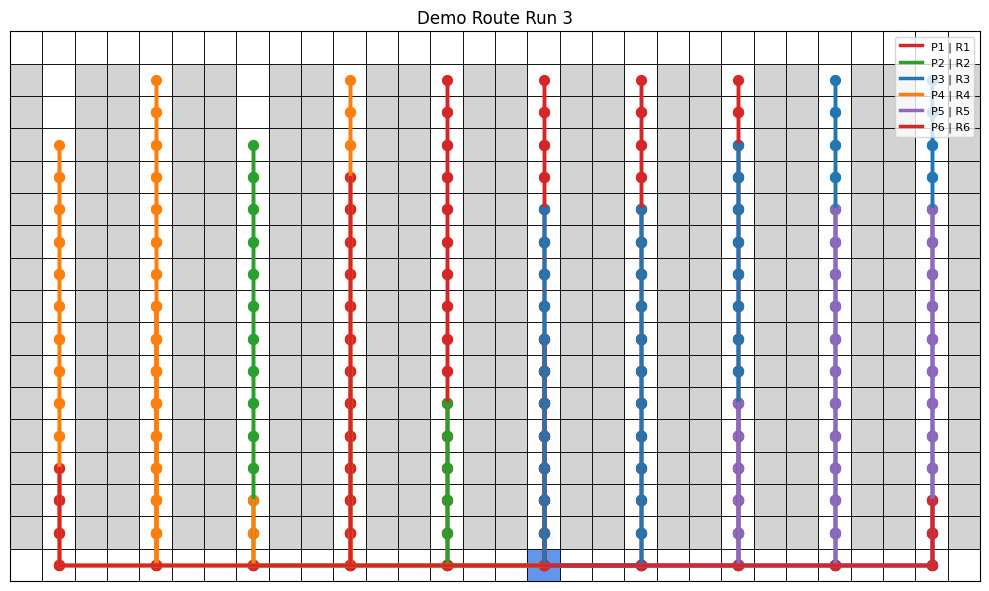


Generated orders for run 4:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A2_01'),
              Item(sku='S1_2', slot='A10_13'),
              Item(sku='S1_3', slot='A8_12'),
              Item(sku='S1_4', slot='A5_04'),
              Item(sku='S1_5', slot='A3_15')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A9_02'),
              Item(sku='S2_2', slot='A4_14'),
              Item(sku='S2_3', slot='A3_11'),
              Item(sku='S2_4', slot='A3_05')],
       size=4),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A9_05'),
              Item(sku='S3_2', slot='A2_08'),
              Item(sku='S3_3', slot='A6_01'),
              Item(sku='S3_4', slot='A10_03'),
              Item(sku='S3_5', slot='A3_07'),
              Item(sku='S3_6', slot='A7_02')],
       size=6),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A9_08'), Item(sku='S4_2', slot='A7_09')],
       size=2),
 Order(order_id='O5', items=[Item(sku='S5_1',

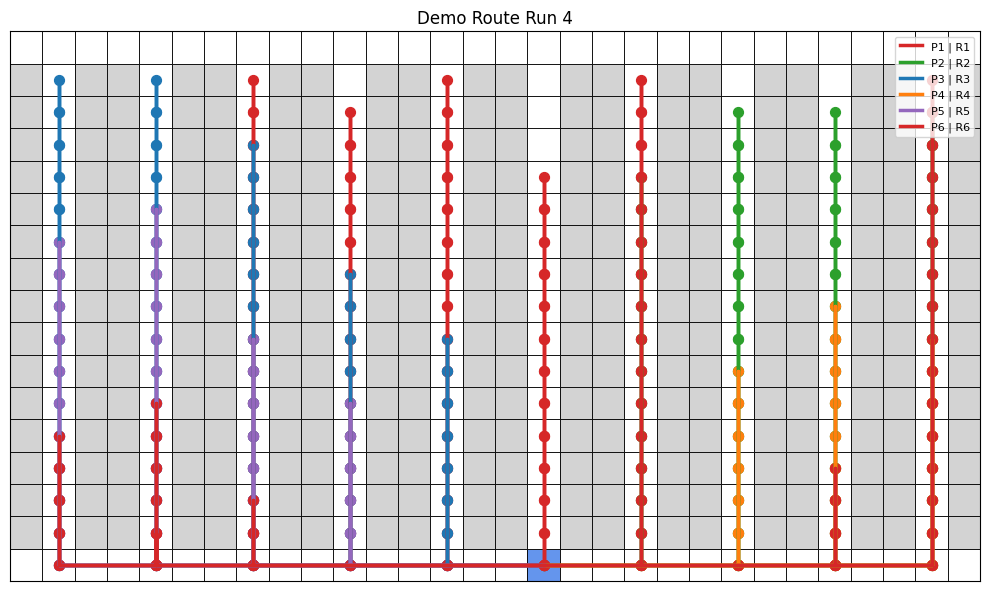


Generated orders for run 5:
[Order(order_id='O1', items=[Item(sku='S1_1', slot='A10_14')], size=1),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A2_11'),
              Item(sku='S2_2', slot='A1_07'),
              Item(sku='S2_3', slot='A1_08'),
              Item(sku='S2_4', slot='A5_09'),
              Item(sku='S2_5', slot='A4_07')],
       size=5),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A4_14'),
              Item(sku='S3_2', slot='A6_02'),
              Item(sku='S3_3', slot='A6_05'),
              Item(sku='S3_4', slot='A7_08')],
       size=4),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A6_06')], size=1),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A10_02'),
              Item(sku='S5_2', slot='A3_02'),
              Item(sku='S5_3', slot='A7_07')],
       size=3),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A2_09')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A7_05'),
              Item(

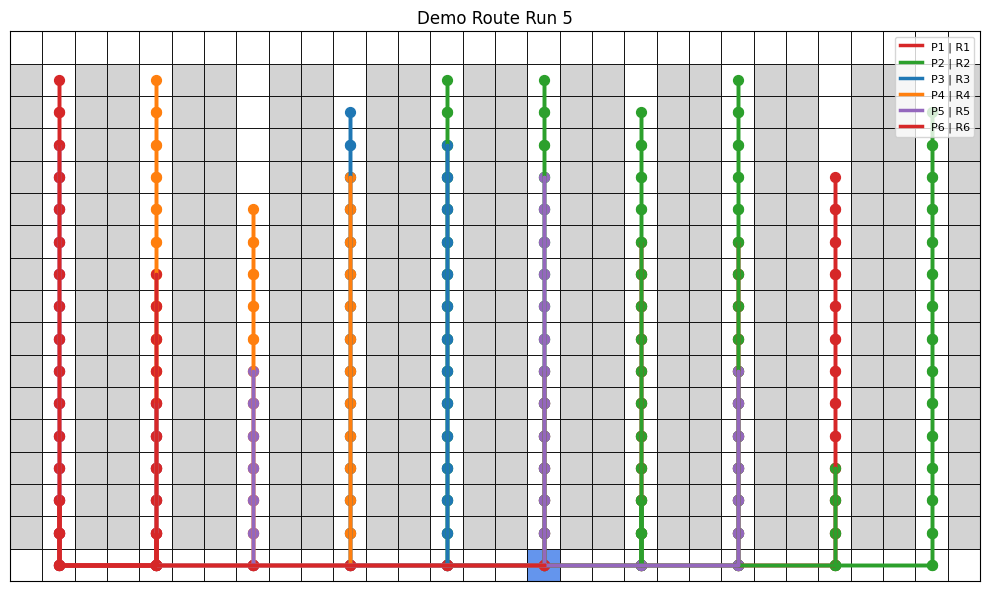


Generated orders for run 6:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A7_14'), Item(sku='S1_2', slot='A9_11')],
       size=2),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A3_05'),
              Item(sku='S2_2', slot='A9_04'),
              Item(sku='S2_3', slot='A1_08')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A6_07'), Item(sku='S3_2', slot='A10_04')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A10_13'),
              Item(sku='S4_2', slot='A10_08'),
              Item(sku='S4_3', slot='A6_02')],
       size=3),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A2_14')], size=1),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A5_15')], size=1),
 Order(order_id='O7',
       items=[Item(sku='S7_1', slot='A3_02'),
              Item(sku='S7_2', slot='A8_08'),
              Item(sku='S7_3', slot='A3_13')],
       size=3),
 Order(order_id='O8',
       items=[Item(sku='S8_1', slot='A9

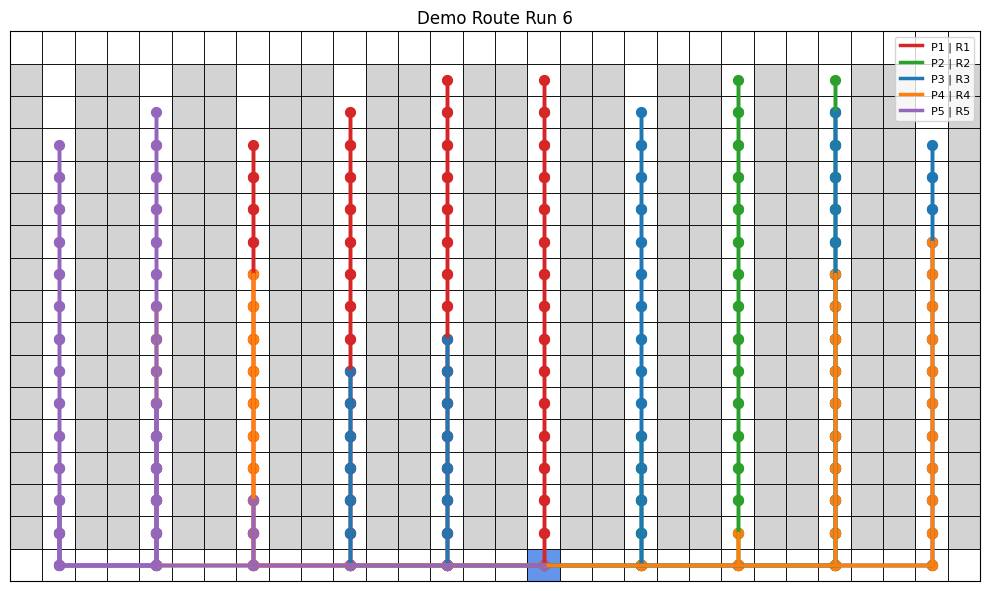


Generated orders for run 7:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A9_14'),
              Item(sku='S1_2', slot='A5_10'),
              Item(sku='S1_3', slot='A1_12'),
              Item(sku='S1_4', slot='A7_13'),
              Item(sku='S1_5', slot='A4_13')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A4_15'),
              Item(sku='S2_2', slot='A2_14'),
              Item(sku='S2_3', slot='A10_06')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A3_05'), Item(sku='S3_2', slot='A5_11')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A4_15'),
              Item(sku='S4_2', slot='A3_06'),
              Item(sku='S4_3', slot='A9_04'),
              Item(sku='S4_4', slot='A8_13'),
              Item(sku='S4_5', slot='A3_05')],
       size=5),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A5_07')], size=1),
 Order(order_id='O6', items=[Item(sku='S6_1', slot='A5_07')], size=

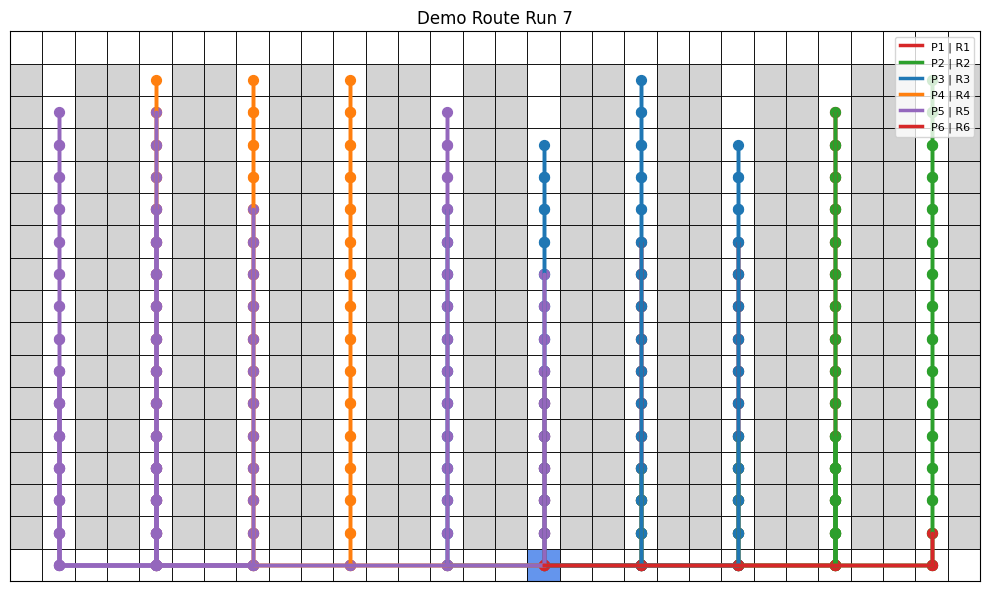


Generated orders for run 8:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A8_04'),
              Item(sku='S1_2', slot='A5_10'),
              Item(sku='S1_3', slot='A8_08'),
              Item(sku='S1_4', slot='A8_13'),
              Item(sku='S1_5', slot='A1_06')],
       size=5),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A5_02'),
              Item(sku='S2_2', slot='A10_14'),
              Item(sku='S2_3', slot='A6_12')],
       size=3),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A6_12'), Item(sku='S3_2', slot='A10_01')],
       size=2),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A2_13'),
              Item(sku='S4_2', slot='A10_08'),
              Item(sku='S4_3', slot='A4_09'),
              Item(sku='S4_4', slot='A7_02'),
              Item(sku='S4_5', slot='A1_06'),
              Item(sku='S4_6', slot='A8_02')],
       size=6),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A7_05')], size=1),
 Order(order_id='O6

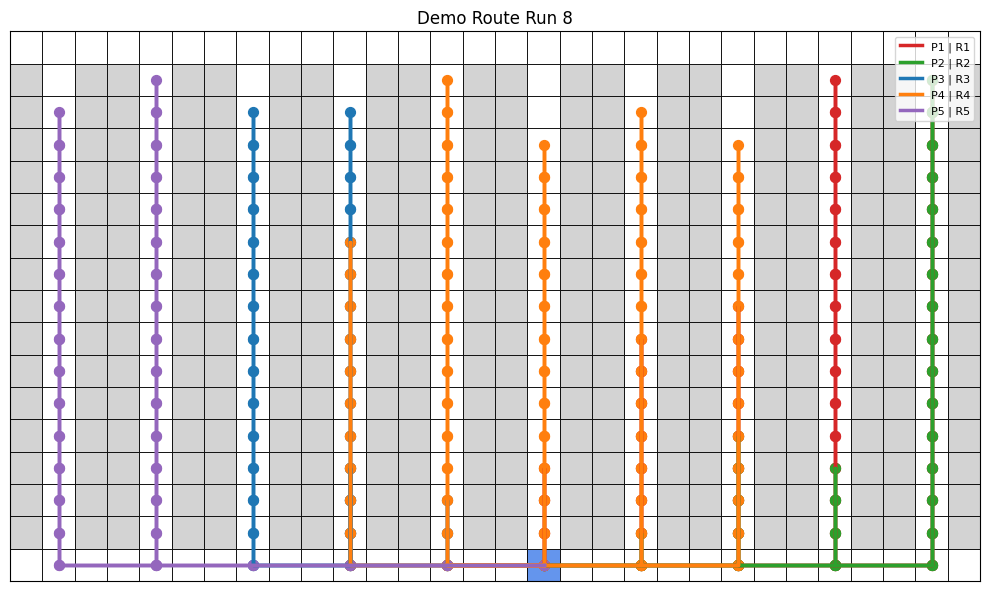


Generated orders for run 9:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A7_06'),
              Item(sku='S1_2', slot='A9_11'),
              Item(sku='S1_3', slot='A2_08')],
       size=3),
 Order(order_id='O2',
       items=[Item(sku='S2_1', slot='A5_14'),
              Item(sku='S2_2', slot='A1_05'),
              Item(sku='S2_3', slot='A7_10'),
              Item(sku='S2_4', slot='A3_02')],
       size=4),
 Order(order_id='O3',
       items=[Item(sku='S3_1', slot='A10_10'),
              Item(sku='S3_2', slot='A2_11'),
              Item(sku='S3_3', slot='A3_14')],
       size=3),
 Order(order_id='O4',
       items=[Item(sku='S4_1', slot='A10_07'), Item(sku='S4_2', slot='A8_09')],
       size=2),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A4_07'),
              Item(sku='S5_2', slot='A4_13'),
              Item(sku='S5_3', slot='A10_05'),
              Item(sku='S5_4', slot='A1_14')],
       size=4),
 Order(order_id='O6',
       items=[Item(sku='S6_1'

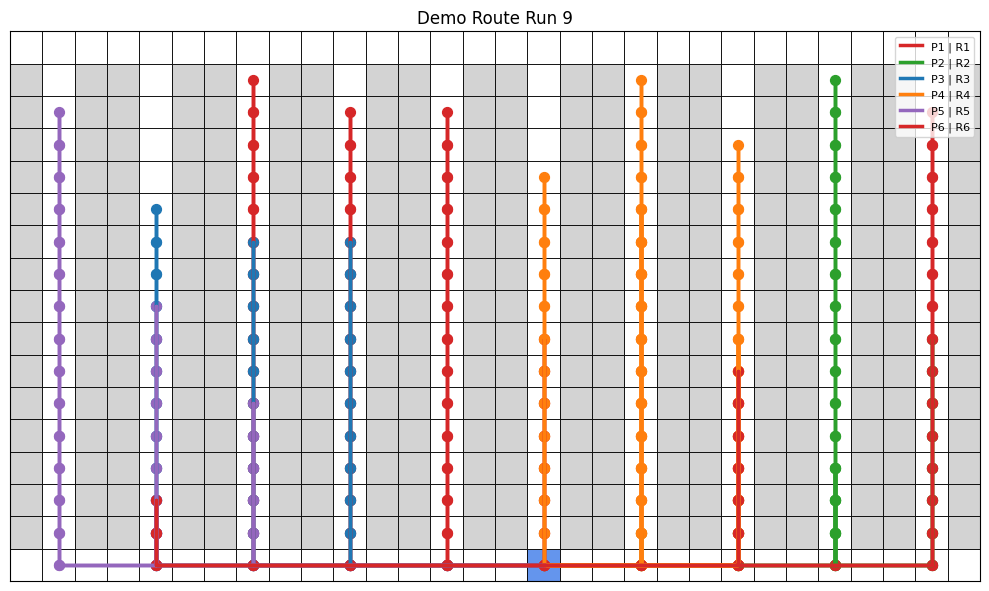


Generated orders for run 10:
[Order(order_id='O1',
       items=[Item(sku='S1_1', slot='A3_10'),
              Item(sku='S1_2', slot='A7_15'),
              Item(sku='S1_3', slot='A2_01'),
              Item(sku='S1_4', slot='A3_14')],
       size=4),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A6_04')], size=1),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A10_05')], size=1),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A5_04')], size=1),
 Order(order_id='O5',
       items=[Item(sku='S5_1', slot='A5_07'),
              Item(sku='S5_2', slot='A4_07'),
              Item(sku='S5_3', slot='A8_11'),
              Item(sku='S5_4', slot='A3_14')],
       size=4),
 Order(order_id='O6',
       items=[Item(sku='S6_1', slot='A10_13'),
              Item(sku='S6_2', slot='A7_13'),
              Item(sku='S6_3', slot='A5_04'),
              Item(sku='S6_4', slot='A9_08'),
              Item(sku='S6_5', slot='A10_02'),
              Item(sku='S6_6', slot='A10_09')],
       s

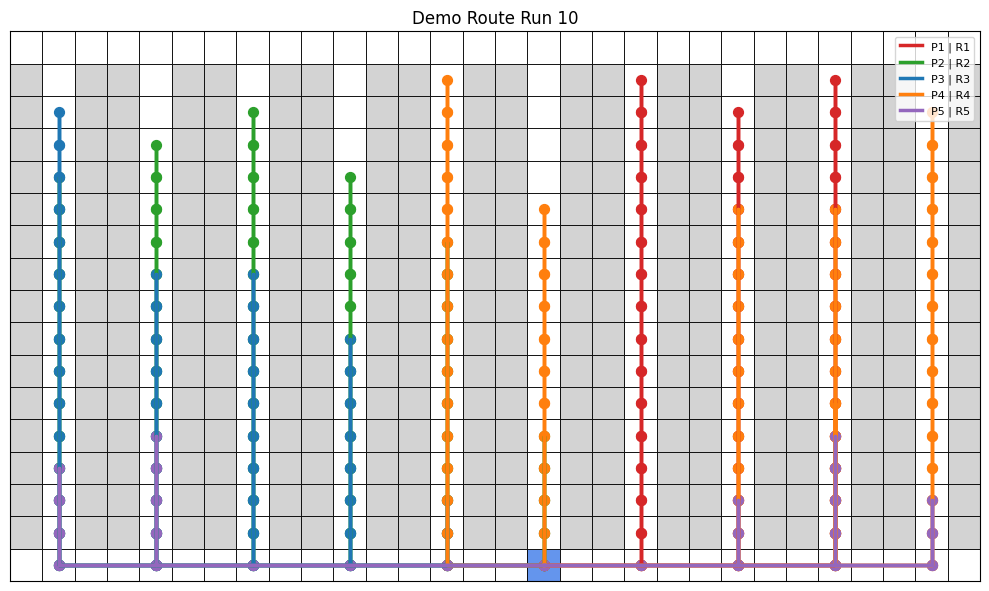


Average distance over 10 runs: 621.4 m
Average travel time (s): 517.8333333333334 s
Average makespan (s): 333.34160625880065


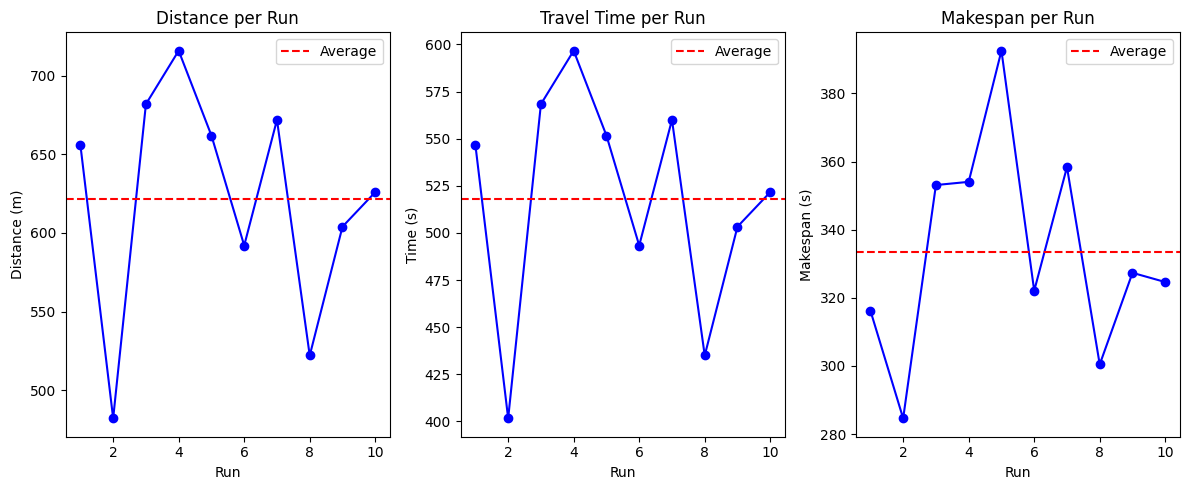

In [47]:
def main(runs) -> None:
    """Demonstrate warehouse functionality."""
    simple_warehouse = Warehouse(
        num_aisles=10,
        slots_per_side=15,
        aisle_length_m=15.0,
        aisle_spacing_m=3.0,
        slot_pitch_m=1.0,
        io_node="F6",
    )
    required_slots = []
    solutions = []
    distances = []
    travel_times = []
    makespans = []

    print("Grid dimensions (rows, cols):", simple_warehouse.grid_dimensions)
    print("\nGrid representation of warehouse:")
    print(simple_warehouse.grid_repr)
    print("\nWarehouse nodes DataFrame:")
    print(simple_warehouse.node_df)
    print("\nAdjacency matrix:")
    print(simple_warehouse.adjacency_matrix)
    print("\nAdjacency dictionary:")
    pprint(simple_warehouse.adjacency_dict)

    for run in range(runs):
        orders = simple_warehouse.generate_orders(
            num_orders=30, max_items_per_order=6, seed=123 + run
        )
        print(f"\nGenerated orders for run {run + 1}:")
        pprint(orders)

        # Required slots
        required = get_required_slots_for_orders([order.order_id for order in orders], orders)
        required_slots.append(required)
        print("\nRequired slots for all orders:", required)

        print("\nGraph representation of warehouse:")
        print(simple_warehouse.generate_layout_text(spacing=6))
        print("\nSlot dict:")
        pprint(simple_warehouse.slot_dict)

        # Generate a demo route
        sol = simple_warehouse.generate_solution(orders, policy=policy_batch_order_picking, bin_size=20)
        solutions.append(sol)
        print("\nGenerated route path:")
        pprint(sol)

        is_valid, message = simple_warehouse.validate_solution(sol, orders)
        print("Route valid?", is_valid, "-", message)

        simple_warehouse.plot_warehouse_routes(sol, title=f"Demo Route Run {run + 1}")

        # Compute metrics
        solution_distance = simple_warehouse.calculate_solution_distance(sol)
        solution_travel_time = simple_warehouse.calculate_solution_travel_time(sol, speed_mps=1.2)

        distances.append(solution_distance)
        travel_times.append(solution_travel_time)

        # Calculate makespan as the longest route's total time
        route_total_times = []
        for route in sol.routes:
            # Estimate travel time for this route (proportional to its length)
            route_length = len(route.path)
            total_length = sum(len(r.path) for r in sol.routes)
            route_travel_time = (route_length / total_length) * solution_travel_time

            # Calculate picking time for the route (assuming 3 seconds per item)
            num_items = sum(len(order.items) for order_id in route.orders
                           for order in orders if order.order_id == order_id)
            picking_time = num_items * 3.0

            # Total time for the route is travel time + picking time
            route_total_time = route_travel_time + picking_time
            route_total_times.append(route_total_time)

        # Makespan is the maximum total time across all routes
        solution_makespan = max(route_total_times)
        makespans.append(solution_makespan)

    # Average metrics
    average_distance = sum(distances) / len(distances)
    average_travel_time = sum(travel_times) / len(travel_times)
    average_makespan = sum(makespans) / len(makespans)

    print("\nAverage distance over", runs, "runs:", average_distance, "m")
    print("Average travel time (s):", average_travel_time, "s")
    print("Average makespan (s):", average_makespan)

    # Plot metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, runs + 1), distances, marker='o', color='blue')
    plt.axhline(y=average_distance, color='red', linestyle='--', label='Average')
    plt.title('Distance per Run')
    plt.xlabel('Run')
    plt.ylabel('Distance (m)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, runs + 1), travel_times, marker='o', color='blue')
    plt.axhline(y=average_travel_time, color='red', linestyle='--', label='Average')
    plt.title('Travel Time per Run')
    plt.xlabel('Run')
    plt.ylabel('Time (s)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, runs + 1), makespans, marker='o', color='blue')
    plt.axhline(y=average_makespan, color='red', linestyle='--', label='Average')
    plt.title('Makespan per Run')
    plt.xlabel('Run')
    plt.ylabel('Makespan (s)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main(10)
